
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 5 - RL <br>
<font color=696880 size=4>
Amirmahdi Meighani


____

# Personal Data

In [1]:
# Set your student number and name
student_number = 401106182
Name = 'Amirhossein'
Last_Name = 'Souri'

# Rules

<font color=red>
Please run all the cells.
</font>

# Q1: Mountain Car (100 Points)

In this notebook we have a game called mountain car. the car is in a valley and at evey moment we can model its state using two floats as speed and location along x axis. You can control the car using three actions.

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

the goal is to reach the peak of mountain in the minimum number of frames. because you get -1 reward for evey timestamp.

you should model the countious enviroment with a approximate descrete one and train your agent using Q learning and SARSA algorithms.


install required libraries

In [2]:
# !pip install numpy
# !pip install matplotlib
# !pip install gymnasium

## imports

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [4]:
def visualize(env):
    '''
    use this function to see the state of the game in the current moment
    '''
    env_screen = env.render()
    plt.imshow(env_screen)
    plt.axis('off');
    title = 'speed is ' + str(env.unwrapped.state[1])

    plt.title(title)
    plt.show()

## Q Learning

in this question we have a countious enviroment but you can approximate it as a discrete enviormnet then learn and act according to that.

you can see the information of game below.

In [5]:
env = gym.make("MountainCar-v0",render_mode='rgb_array',max_episode_steps=200)
spec = gym.spec('MountainCar-v0')

Action Space: Discrete(3)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: -110.0



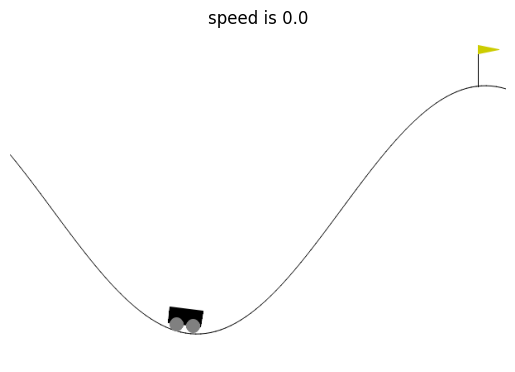

In [6]:
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")
env.reset()
visualize(env)

Observation Space:
The observation is a ndarray with shape (2,) where the elements correspond to the following:

| Num |              Observation             |  Min  |  Max |
|:---:|:------------------------------------:|:-----:|:----:|
|  0  | position of the car along the x-axis |  -1.2 |  0.6 |
|  1  | velocity of the car                  | -0.07 | 0.07 |

Action Space:
There are 3 discrete deterministic actions:

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

You can play in this env yourself!!!

Try some actions and visulize the env after every 5 action. use env.step(action) function to do actions. print output of some step function. It returns five values :

new_state, reward, is_terminated ,is_truncated ,extra_info

new state after the action, reward for that action in that step, is the game terminated by reaching the goal, is the game finished by reaching 200 episode limit that is the default in this game, and some possible extra info that we don't use.


(array([-0.53578377, -0.00091549], dtype=float32), -1.0, False, False, {})


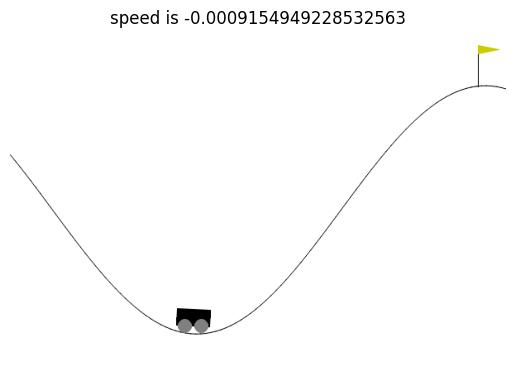

(array([-0.53660786, -0.00082413], dtype=float32), -1.0, False, False, {})


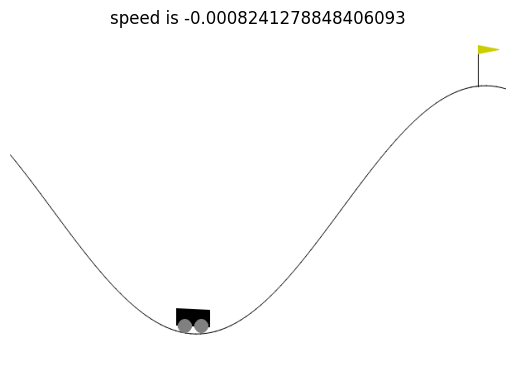

(array([-5.3633446e-01,  2.7341570e-04], dtype=float32), -1.0, False, False, {})


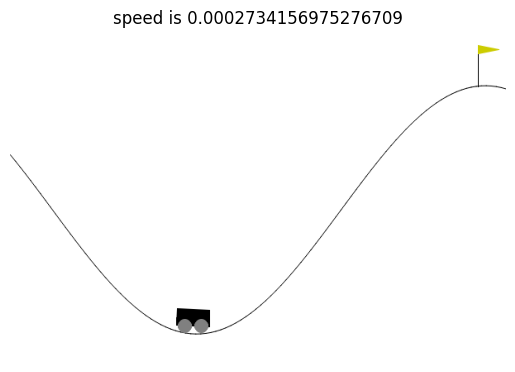

(array([-0.5349656 ,  0.00136891], dtype=float32), -1.0, False, False, {})


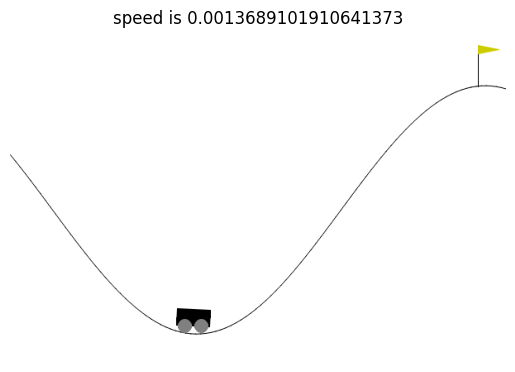

(array([-0.5325114 ,  0.00245414], dtype=float32), -1.0, False, False, {})


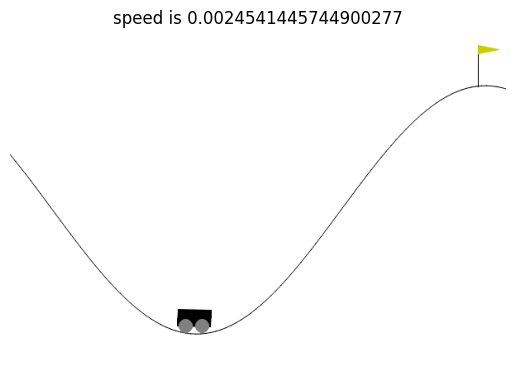

(array([-0.4636165,  0.       ], dtype=float32), {})

In [7]:
env.reset()

print(env.step(0))
visualize(env)
print(env.step(1))
visualize(env)
print(env.step(2))
visualize(env)
print(env.step(2))
visualize(env)
print(env.step(2))
visualize(env)

env.reset()

the state consists of two floats.  first one is position in x axis and second one is speed. in the next cell we will write our agent. First we need to convert continuous state to descrete so complete the relevant functions. after that we need to train our agent using Q_learning formula:


$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

After training we use create policy to save your best actions. Then evaluate your policy.

In [8]:
class MountainCarQL:

    def __init__(self, env, discrete_size=20):
        self.discrete_size = discrete_size # number of states we use instead of each continuous argument of state
        self.env = env
        self.q_values = self.create_q_values_list()
        self.policy = {}
        

    def create_q_values_list(self):
        return np.zeros((self.discrete_size, self.discrete_size, self.env.action_space.n))


    def get_discrete_state(self, state):
        step = (self.env.observation_space.high - self.env.observation_space.low) / self.discrete_size
        state -= self.env.observation_space.low
        gap = state // step
        gap = gap.astype('int32')
        for i in range(len(gap)):
            if gap[i] >= self.discrete_size:
                gap[i] = self.discrete_size - 1
            elif gap[i] < 0:
                gap[i] = 0
        return tuple(gap.astype('int32'))
    
    
    def learn(self, num_episodes, alpha, gamma, epsilon):
        for e in range(num_episodes):
            state = self.env.reset()[0]
            discrete_state = self.get_discrete_state(state)
            end = False
            
            while not end:
                if np.random.random() < epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.q_values[discrete_state])
                    
                new_state, reward, is_terminated, is_truncated, info = self.env.step(action)
                new_discrete_state = self.get_discrete_state(new_state)
                end = is_terminated or is_truncated
                
                if end and new_state[0] >= self.env.goal_position:
                    print('Achieved Goal in iteration', e)
                    self.q_values[discrete_state + (action, )] = 10
                else:
                    best_q_after_action = np.max(self.q_values[new_discrete_state])
                    current_q = self.q_values[discrete_state + (action, )]
                    updated_q = (1 - alpha) * current_q + alpha * (reward + gamma * best_q_after_action)
                    self.q_values[discrete_state + (action, )] = updated_q
                    
                discrete_state = new_discrete_state


    def create_policy(self):
        """
        Create your policy in this function after your agent learns the q_values.
        """
        for i in range(self.discrete_size):
            for j in range(self.discrete_size):
                self.policy[(i, j)] = np.argmax(self.q_values[(i, j)])
        

    def act(self, state):
        """
        Move your agent one step according to your policy.
        """
        discrete_state = self.get_discrete_state(state)
        return self.policy[discrete_state]


#     showing path is included in this function
    def evaluate(self, num_episodes, show_path=False):
        """
        Sample num_episodes episodes from your agent that acts according to your policy.
        Then return the average rewards it gets and percentage of episodes that your car reached the goal.

        Inputs:
            - num_episodes: Number of episodes for sampling.
        Returns:
            tuple: average reward and win percentage
        """
        sum_rewards = 0
        num_wins = 0
        for e in range(num_episodes):
            i = 0
            state = self.env.reset()[0]
            discrete_state = self.get_discrete_state(state)
            end = False
            current_reward = 0
            while not end:
                if i % 10 == 0 and e == 0:
                    print(i)
                    visualize(env)
                i += 1
                action = self.act(state)
                new_state, reward, is_terminated, is_truncated, info = self.env.step(action)
                current_reward += reward
                end = is_terminated or is_truncated
                if end and new_state[0] >= self.env.goal_position:
                    num_wins += 1
                state = new_state
            sum_rewards += current_reward
            
        average_reward = sum_rewards / num_episodes
        win_percentage = num_wins / num_episodes * 100
        return average_reward, int(win_percentage)

train your agent with good parameters

In [9]:
EPISODES = 10000
LEARNING_RATE = 0.2
DISCOUNT = 0.95
EPSILON = 0.2
DISCRETE_SIZE = 30


mountain_car_ql = MountainCarQL(env, discrete_size=DISCRETE_SIZE)
mountain_car_ql.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)

Achieved Goal in iteration 0
Achieved Goal in iteration 1
Achieved Goal in iteration 2
Achieved Goal in iteration 3
Achieved Goal in iteration 4
Achieved Goal in iteration 5
Achieved Goal in iteration 6
Achieved Goal in iteration 7
Achieved Goal in iteration 8
Achieved Goal in iteration 9
Achieved Goal in iteration 10
Achieved Goal in iteration 11
Achieved Goal in iteration 12
Achieved Goal in iteration 13
Achieved Goal in iteration 14
Achieved Goal in iteration 15
Achieved Goal in iteration 16
Achieved Goal in iteration 17
Achieved Goal in iteration 18
Achieved Goal in iteration 19
Achieved Goal in iteration 20
Achieved Goal in iteration 21
Achieved Goal in iteration 23
Achieved Goal in iteration 24
Achieved Goal in iteration 25
Achieved Goal in iteration 26
Achieved Goal in iteration 27
Achieved Goal in iteration 29
Achieved Goal in iteration 30
Achieved Goal in iteration 31
Achieved Goal in iteration 32
Achieved Goal in iteration 34
Achieved Goal in iteration 35
Achieved Goal in ite

C:\Users\Ausu\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.goal_position to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.goal_position` for environment variables or `env.get_wrapper_attr('goal_position')` that will search the reminding wrappers.
  logger.warn(


Achieved Goal in iteration 50
Achieved Goal in iteration 52
Achieved Goal in iteration 53
Achieved Goal in iteration 54
Achieved Goal in iteration 55
Achieved Goal in iteration 56
Achieved Goal in iteration 57
Achieved Goal in iteration 58
Achieved Goal in iteration 59
Achieved Goal in iteration 62
Achieved Goal in iteration 63
Achieved Goal in iteration 64
Achieved Goal in iteration 66
Achieved Goal in iteration 69
Achieved Goal in iteration 70
Achieved Goal in iteration 72
Achieved Goal in iteration 73
Achieved Goal in iteration 76
Achieved Goal in iteration 77
Achieved Goal in iteration 78
Achieved Goal in iteration 79
Achieved Goal in iteration 83
Achieved Goal in iteration 85
Achieved Goal in iteration 86
Achieved Goal in iteration 87
Achieved Goal in iteration 88
Achieved Goal in iteration 90
Achieved Goal in iteration 92
Achieved Goal in iteration 93
Achieved Goal in iteration 94
Achieved Goal in iteration 95
Achieved Goal in iteration 98
Achieved Goal in iteration 99
Achieved G

Achieved Goal in iteration 385
Achieved Goal in iteration 386
Achieved Goal in iteration 387
Achieved Goal in iteration 388
Achieved Goal in iteration 389
Achieved Goal in iteration 390
Achieved Goal in iteration 391
Achieved Goal in iteration 392
Achieved Goal in iteration 393
Achieved Goal in iteration 394
Achieved Goal in iteration 395
Achieved Goal in iteration 396
Achieved Goal in iteration 397
Achieved Goal in iteration 398
Achieved Goal in iteration 399
Achieved Goal in iteration 400
Achieved Goal in iteration 401
Achieved Goal in iteration 402
Achieved Goal in iteration 403
Achieved Goal in iteration 404
Achieved Goal in iteration 405
Achieved Goal in iteration 406
Achieved Goal in iteration 407
Achieved Goal in iteration 408
Achieved Goal in iteration 409
Achieved Goal in iteration 410
Achieved Goal in iteration 411
Achieved Goal in iteration 412
Achieved Goal in iteration 413
Achieved Goal in iteration 414
Achieved Goal in iteration 415
Achieved Goal in iteration 416
Achieved

Achieved Goal in iteration 739
Achieved Goal in iteration 740
Achieved Goal in iteration 741
Achieved Goal in iteration 742
Achieved Goal in iteration 743
Achieved Goal in iteration 744
Achieved Goal in iteration 745
Achieved Goal in iteration 746
Achieved Goal in iteration 747
Achieved Goal in iteration 748
Achieved Goal in iteration 749
Achieved Goal in iteration 750
Achieved Goal in iteration 751
Achieved Goal in iteration 752
Achieved Goal in iteration 753
Achieved Goal in iteration 755
Achieved Goal in iteration 756
Achieved Goal in iteration 757
Achieved Goal in iteration 758
Achieved Goal in iteration 760
Achieved Goal in iteration 762
Achieved Goal in iteration 763
Achieved Goal in iteration 764
Achieved Goal in iteration 765
Achieved Goal in iteration 766
Achieved Goal in iteration 767
Achieved Goal in iteration 768
Achieved Goal in iteration 769
Achieved Goal in iteration 770
Achieved Goal in iteration 771
Achieved Goal in iteration 772
Achieved Goal in iteration 773
Achieved

Achieved Goal in iteration 1081
Achieved Goal in iteration 1082
Achieved Goal in iteration 1083
Achieved Goal in iteration 1084
Achieved Goal in iteration 1085
Achieved Goal in iteration 1086
Achieved Goal in iteration 1087
Achieved Goal in iteration 1088
Achieved Goal in iteration 1089
Achieved Goal in iteration 1090
Achieved Goal in iteration 1091
Achieved Goal in iteration 1092
Achieved Goal in iteration 1093
Achieved Goal in iteration 1094
Achieved Goal in iteration 1095
Achieved Goal in iteration 1096
Achieved Goal in iteration 1097
Achieved Goal in iteration 1098
Achieved Goal in iteration 1099
Achieved Goal in iteration 1100
Achieved Goal in iteration 1101
Achieved Goal in iteration 1102
Achieved Goal in iteration 1103
Achieved Goal in iteration 1104
Achieved Goal in iteration 1105
Achieved Goal in iteration 1106
Achieved Goal in iteration 1107
Achieved Goal in iteration 1108
Achieved Goal in iteration 1109
Achieved Goal in iteration 1110
Achieved Goal in iteration 1111
Achieved

Achieved Goal in iteration 1364
Achieved Goal in iteration 1365
Achieved Goal in iteration 1366
Achieved Goal in iteration 1367
Achieved Goal in iteration 1368
Achieved Goal in iteration 1369
Achieved Goal in iteration 1370
Achieved Goal in iteration 1371
Achieved Goal in iteration 1372
Achieved Goal in iteration 1373
Achieved Goal in iteration 1374
Achieved Goal in iteration 1375
Achieved Goal in iteration 1376
Achieved Goal in iteration 1377
Achieved Goal in iteration 1378
Achieved Goal in iteration 1379
Achieved Goal in iteration 1380
Achieved Goal in iteration 1381
Achieved Goal in iteration 1382
Achieved Goal in iteration 1383
Achieved Goal in iteration 1384
Achieved Goal in iteration 1385
Achieved Goal in iteration 1386
Achieved Goal in iteration 1387
Achieved Goal in iteration 1388
Achieved Goal in iteration 1389
Achieved Goal in iteration 1390
Achieved Goal in iteration 1391
Achieved Goal in iteration 1392
Achieved Goal in iteration 1393
Achieved Goal in iteration 1395
Achieved

Achieved Goal in iteration 1704
Achieved Goal in iteration 1705
Achieved Goal in iteration 1706
Achieved Goal in iteration 1707
Achieved Goal in iteration 1708
Achieved Goal in iteration 1709
Achieved Goal in iteration 1710
Achieved Goal in iteration 1711
Achieved Goal in iteration 1712
Achieved Goal in iteration 1713
Achieved Goal in iteration 1714
Achieved Goal in iteration 1715
Achieved Goal in iteration 1716
Achieved Goal in iteration 1717
Achieved Goal in iteration 1718
Achieved Goal in iteration 1719
Achieved Goal in iteration 1720
Achieved Goal in iteration 1721
Achieved Goal in iteration 1722
Achieved Goal in iteration 1723
Achieved Goal in iteration 1724
Achieved Goal in iteration 1725
Achieved Goal in iteration 1726
Achieved Goal in iteration 1727
Achieved Goal in iteration 1728
Achieved Goal in iteration 1729
Achieved Goal in iteration 1730
Achieved Goal in iteration 1731
Achieved Goal in iteration 1732
Achieved Goal in iteration 1733
Achieved Goal in iteration 1734
Achieved

Achieved Goal in iteration 1979
Achieved Goal in iteration 1980
Achieved Goal in iteration 1981
Achieved Goal in iteration 1982
Achieved Goal in iteration 1983
Achieved Goal in iteration 1984
Achieved Goal in iteration 1985
Achieved Goal in iteration 1986
Achieved Goal in iteration 1987
Achieved Goal in iteration 1988
Achieved Goal in iteration 1989
Achieved Goal in iteration 1990
Achieved Goal in iteration 1991
Achieved Goal in iteration 1992
Achieved Goal in iteration 1993
Achieved Goal in iteration 1994
Achieved Goal in iteration 1995
Achieved Goal in iteration 1996
Achieved Goal in iteration 1997
Achieved Goal in iteration 1998
Achieved Goal in iteration 1999
Achieved Goal in iteration 2000
Achieved Goal in iteration 2001
Achieved Goal in iteration 2002
Achieved Goal in iteration 2003
Achieved Goal in iteration 2004
Achieved Goal in iteration 2005
Achieved Goal in iteration 2006
Achieved Goal in iteration 2007
Achieved Goal in iteration 2008
Achieved Goal in iteration 2009
Achieved

Achieved Goal in iteration 2280
Achieved Goal in iteration 2281
Achieved Goal in iteration 2282
Achieved Goal in iteration 2283
Achieved Goal in iteration 2284
Achieved Goal in iteration 2285
Achieved Goal in iteration 2286
Achieved Goal in iteration 2287
Achieved Goal in iteration 2288
Achieved Goal in iteration 2289
Achieved Goal in iteration 2290
Achieved Goal in iteration 2291
Achieved Goal in iteration 2293
Achieved Goal in iteration 2295
Achieved Goal in iteration 2296
Achieved Goal in iteration 2297
Achieved Goal in iteration 2298
Achieved Goal in iteration 2299
Achieved Goal in iteration 2300
Achieved Goal in iteration 2301
Achieved Goal in iteration 2302
Achieved Goal in iteration 2303
Achieved Goal in iteration 2304
Achieved Goal in iteration 2305
Achieved Goal in iteration 2306
Achieved Goal in iteration 2307
Achieved Goal in iteration 2308
Achieved Goal in iteration 2309
Achieved Goal in iteration 2310
Achieved Goal in iteration 2311
Achieved Goal in iteration 2312
Achieved

Achieved Goal in iteration 2561
Achieved Goal in iteration 2563
Achieved Goal in iteration 2564
Achieved Goal in iteration 2565
Achieved Goal in iteration 2566
Achieved Goal in iteration 2567
Achieved Goal in iteration 2568
Achieved Goal in iteration 2569
Achieved Goal in iteration 2570
Achieved Goal in iteration 2571
Achieved Goal in iteration 2573
Achieved Goal in iteration 2575
Achieved Goal in iteration 2576
Achieved Goal in iteration 2577
Achieved Goal in iteration 2579
Achieved Goal in iteration 2580
Achieved Goal in iteration 2581
Achieved Goal in iteration 2582
Achieved Goal in iteration 2583
Achieved Goal in iteration 2584
Achieved Goal in iteration 2585
Achieved Goal in iteration 2586
Achieved Goal in iteration 2587
Achieved Goal in iteration 2588
Achieved Goal in iteration 2589
Achieved Goal in iteration 2597
Achieved Goal in iteration 2599
Achieved Goal in iteration 2600
Achieved Goal in iteration 2601
Achieved Goal in iteration 2602
Achieved Goal in iteration 2603
Achieved

Achieved Goal in iteration 2865
Achieved Goal in iteration 2866
Achieved Goal in iteration 2867
Achieved Goal in iteration 2868
Achieved Goal in iteration 2869
Achieved Goal in iteration 2870
Achieved Goal in iteration 2871
Achieved Goal in iteration 2872
Achieved Goal in iteration 2873
Achieved Goal in iteration 2874
Achieved Goal in iteration 2875
Achieved Goal in iteration 2876
Achieved Goal in iteration 2877
Achieved Goal in iteration 2878
Achieved Goal in iteration 2879
Achieved Goal in iteration 2880
Achieved Goal in iteration 2881
Achieved Goal in iteration 2882
Achieved Goal in iteration 2883
Achieved Goal in iteration 2884
Achieved Goal in iteration 2885
Achieved Goal in iteration 2886
Achieved Goal in iteration 2887
Achieved Goal in iteration 2888
Achieved Goal in iteration 2889
Achieved Goal in iteration 2890
Achieved Goal in iteration 2891
Achieved Goal in iteration 2892
Achieved Goal in iteration 2893
Achieved Goal in iteration 2894
Achieved Goal in iteration 2895
Achieved

Achieved Goal in iteration 3127
Achieved Goal in iteration 3128
Achieved Goal in iteration 3129
Achieved Goal in iteration 3130
Achieved Goal in iteration 3131
Achieved Goal in iteration 3132
Achieved Goal in iteration 3133
Achieved Goal in iteration 3134
Achieved Goal in iteration 3135
Achieved Goal in iteration 3136
Achieved Goal in iteration 3137
Achieved Goal in iteration 3138
Achieved Goal in iteration 3139
Achieved Goal in iteration 3140
Achieved Goal in iteration 3141
Achieved Goal in iteration 3142
Achieved Goal in iteration 3143
Achieved Goal in iteration 3144
Achieved Goal in iteration 3145
Achieved Goal in iteration 3146
Achieved Goal in iteration 3147
Achieved Goal in iteration 3148
Achieved Goal in iteration 3150
Achieved Goal in iteration 3151
Achieved Goal in iteration 3152
Achieved Goal in iteration 3153
Achieved Goal in iteration 3154
Achieved Goal in iteration 3155
Achieved Goal in iteration 3156
Achieved Goal in iteration 3157
Achieved Goal in iteration 3158
Achieved

Achieved Goal in iteration 3400
Achieved Goal in iteration 3401
Achieved Goal in iteration 3402
Achieved Goal in iteration 3403
Achieved Goal in iteration 3404
Achieved Goal in iteration 3405
Achieved Goal in iteration 3406
Achieved Goal in iteration 3407
Achieved Goal in iteration 3408
Achieved Goal in iteration 3409
Achieved Goal in iteration 3411
Achieved Goal in iteration 3412
Achieved Goal in iteration 3413
Achieved Goal in iteration 3414
Achieved Goal in iteration 3415
Achieved Goal in iteration 3416
Achieved Goal in iteration 3417
Achieved Goal in iteration 3418
Achieved Goal in iteration 3419
Achieved Goal in iteration 3420
Achieved Goal in iteration 3421
Achieved Goal in iteration 3422
Achieved Goal in iteration 3423
Achieved Goal in iteration 3424
Achieved Goal in iteration 3425
Achieved Goal in iteration 3426
Achieved Goal in iteration 3427
Achieved Goal in iteration 3428
Achieved Goal in iteration 3430
Achieved Goal in iteration 3432
Achieved Goal in iteration 3433
Achieved

Achieved Goal in iteration 3725
Achieved Goal in iteration 3726
Achieved Goal in iteration 3727
Achieved Goal in iteration 3728
Achieved Goal in iteration 3729
Achieved Goal in iteration 3730
Achieved Goal in iteration 3731
Achieved Goal in iteration 3732
Achieved Goal in iteration 3733
Achieved Goal in iteration 3734
Achieved Goal in iteration 3735
Achieved Goal in iteration 3736
Achieved Goal in iteration 3737
Achieved Goal in iteration 3738
Achieved Goal in iteration 3739
Achieved Goal in iteration 3740
Achieved Goal in iteration 3742
Achieved Goal in iteration 3745
Achieved Goal in iteration 3746
Achieved Goal in iteration 3750
Achieved Goal in iteration 3751
Achieved Goal in iteration 3753
Achieved Goal in iteration 3754
Achieved Goal in iteration 3756
Achieved Goal in iteration 3757
Achieved Goal in iteration 3758
Achieved Goal in iteration 3759
Achieved Goal in iteration 3760
Achieved Goal in iteration 3761
Achieved Goal in iteration 3762
Achieved Goal in iteration 3763
Achieved

Achieved Goal in iteration 4039
Achieved Goal in iteration 4040
Achieved Goal in iteration 4041
Achieved Goal in iteration 4042
Achieved Goal in iteration 4043
Achieved Goal in iteration 4045
Achieved Goal in iteration 4046
Achieved Goal in iteration 4048
Achieved Goal in iteration 4050
Achieved Goal in iteration 4051
Achieved Goal in iteration 4053
Achieved Goal in iteration 4054
Achieved Goal in iteration 4056
Achieved Goal in iteration 4057
Achieved Goal in iteration 4061
Achieved Goal in iteration 4062
Achieved Goal in iteration 4063
Achieved Goal in iteration 4065
Achieved Goal in iteration 4066
Achieved Goal in iteration 4067
Achieved Goal in iteration 4073
Achieved Goal in iteration 4075
Achieved Goal in iteration 4078
Achieved Goal in iteration 4079
Achieved Goal in iteration 4080
Achieved Goal in iteration 4081
Achieved Goal in iteration 4082
Achieved Goal in iteration 4087
Achieved Goal in iteration 4088
Achieved Goal in iteration 4089
Achieved Goal in iteration 4090
Achieved

Achieved Goal in iteration 4450
Achieved Goal in iteration 4451
Achieved Goal in iteration 4452
Achieved Goal in iteration 4454
Achieved Goal in iteration 4455
Achieved Goal in iteration 4457
Achieved Goal in iteration 4458
Achieved Goal in iteration 4460
Achieved Goal in iteration 4462
Achieved Goal in iteration 4464
Achieved Goal in iteration 4465
Achieved Goal in iteration 4466
Achieved Goal in iteration 4467
Achieved Goal in iteration 4468
Achieved Goal in iteration 4469
Achieved Goal in iteration 4470
Achieved Goal in iteration 4471
Achieved Goal in iteration 4472
Achieved Goal in iteration 4473
Achieved Goal in iteration 4474
Achieved Goal in iteration 4477
Achieved Goal in iteration 4479
Achieved Goal in iteration 4481
Achieved Goal in iteration 4483
Achieved Goal in iteration 4484
Achieved Goal in iteration 4486
Achieved Goal in iteration 4487
Achieved Goal in iteration 4488
Achieved Goal in iteration 4489
Achieved Goal in iteration 4491
Achieved Goal in iteration 4493
Achieved

Achieved Goal in iteration 4808
Achieved Goal in iteration 4809
Achieved Goal in iteration 4812
Achieved Goal in iteration 4815
Achieved Goal in iteration 4817
Achieved Goal in iteration 4819
Achieved Goal in iteration 4821
Achieved Goal in iteration 4822
Achieved Goal in iteration 4823
Achieved Goal in iteration 4826
Achieved Goal in iteration 4827
Achieved Goal in iteration 4828
Achieved Goal in iteration 4829
Achieved Goal in iteration 4830
Achieved Goal in iteration 4831
Achieved Goal in iteration 4832
Achieved Goal in iteration 4833
Achieved Goal in iteration 4834
Achieved Goal in iteration 4835
Achieved Goal in iteration 4836
Achieved Goal in iteration 4837
Achieved Goal in iteration 4838
Achieved Goal in iteration 4840
Achieved Goal in iteration 4842
Achieved Goal in iteration 4843
Achieved Goal in iteration 4844
Achieved Goal in iteration 4845
Achieved Goal in iteration 4846
Achieved Goal in iteration 4849
Achieved Goal in iteration 4850
Achieved Goal in iteration 4854
Achieved

Achieved Goal in iteration 5120
Achieved Goal in iteration 5121
Achieved Goal in iteration 5122
Achieved Goal in iteration 5123
Achieved Goal in iteration 5124
Achieved Goal in iteration 5125
Achieved Goal in iteration 5126
Achieved Goal in iteration 5127
Achieved Goal in iteration 5128
Achieved Goal in iteration 5129
Achieved Goal in iteration 5130
Achieved Goal in iteration 5131
Achieved Goal in iteration 5132
Achieved Goal in iteration 5133
Achieved Goal in iteration 5134
Achieved Goal in iteration 5135
Achieved Goal in iteration 5136
Achieved Goal in iteration 5137
Achieved Goal in iteration 5138
Achieved Goal in iteration 5139
Achieved Goal in iteration 5140
Achieved Goal in iteration 5141
Achieved Goal in iteration 5142
Achieved Goal in iteration 5143
Achieved Goal in iteration 5144
Achieved Goal in iteration 5145
Achieved Goal in iteration 5146
Achieved Goal in iteration 5147
Achieved Goal in iteration 5148
Achieved Goal in iteration 5149
Achieved Goal in iteration 5150
Achieved

Achieved Goal in iteration 5447
Achieved Goal in iteration 5448
Achieved Goal in iteration 5449
Achieved Goal in iteration 5450
Achieved Goal in iteration 5451
Achieved Goal in iteration 5452
Achieved Goal in iteration 5453
Achieved Goal in iteration 5454
Achieved Goal in iteration 5455
Achieved Goal in iteration 5456
Achieved Goal in iteration 5457
Achieved Goal in iteration 5458
Achieved Goal in iteration 5459
Achieved Goal in iteration 5460
Achieved Goal in iteration 5461
Achieved Goal in iteration 5462
Achieved Goal in iteration 5463
Achieved Goal in iteration 5464
Achieved Goal in iteration 5465
Achieved Goal in iteration 5466
Achieved Goal in iteration 5467
Achieved Goal in iteration 5468
Achieved Goal in iteration 5469
Achieved Goal in iteration 5470
Achieved Goal in iteration 5471
Achieved Goal in iteration 5472
Achieved Goal in iteration 5473
Achieved Goal in iteration 5474
Achieved Goal in iteration 5475
Achieved Goal in iteration 5476
Achieved Goal in iteration 5477
Achieved

Achieved Goal in iteration 5736
Achieved Goal in iteration 5737
Achieved Goal in iteration 5738
Achieved Goal in iteration 5739
Achieved Goal in iteration 5740
Achieved Goal in iteration 5741
Achieved Goal in iteration 5742
Achieved Goal in iteration 5743
Achieved Goal in iteration 5744
Achieved Goal in iteration 5745
Achieved Goal in iteration 5746
Achieved Goal in iteration 5747
Achieved Goal in iteration 5748
Achieved Goal in iteration 5749
Achieved Goal in iteration 5750
Achieved Goal in iteration 5752
Achieved Goal in iteration 5753
Achieved Goal in iteration 5754
Achieved Goal in iteration 5756
Achieved Goal in iteration 5757
Achieved Goal in iteration 5758
Achieved Goal in iteration 5759
Achieved Goal in iteration 5760
Achieved Goal in iteration 5761
Achieved Goal in iteration 5762
Achieved Goal in iteration 5763
Achieved Goal in iteration 5764
Achieved Goal in iteration 5765
Achieved Goal in iteration 5766
Achieved Goal in iteration 5767
Achieved Goal in iteration 5768
Achieved

Achieved Goal in iteration 6045
Achieved Goal in iteration 6046
Achieved Goal in iteration 6048
Achieved Goal in iteration 6050
Achieved Goal in iteration 6051
Achieved Goal in iteration 6053
Achieved Goal in iteration 6054
Achieved Goal in iteration 6055
Achieved Goal in iteration 6057
Achieved Goal in iteration 6058
Achieved Goal in iteration 6059
Achieved Goal in iteration 6060
Achieved Goal in iteration 6061
Achieved Goal in iteration 6062
Achieved Goal in iteration 6063
Achieved Goal in iteration 6064
Achieved Goal in iteration 6065
Achieved Goal in iteration 6068
Achieved Goal in iteration 6069
Achieved Goal in iteration 6070
Achieved Goal in iteration 6071
Achieved Goal in iteration 6072
Achieved Goal in iteration 6073
Achieved Goal in iteration 6074
Achieved Goal in iteration 6075
Achieved Goal in iteration 6076
Achieved Goal in iteration 6080
Achieved Goal in iteration 6081
Achieved Goal in iteration 6084
Achieved Goal in iteration 6085
Achieved Goal in iteration 6086
Achieved

Achieved Goal in iteration 6378
Achieved Goal in iteration 6379
Achieved Goal in iteration 6380
Achieved Goal in iteration 6381
Achieved Goal in iteration 6382
Achieved Goal in iteration 6383
Achieved Goal in iteration 6384
Achieved Goal in iteration 6385
Achieved Goal in iteration 6386
Achieved Goal in iteration 6387
Achieved Goal in iteration 6388
Achieved Goal in iteration 6389
Achieved Goal in iteration 6390
Achieved Goal in iteration 6391
Achieved Goal in iteration 6392
Achieved Goal in iteration 6393
Achieved Goal in iteration 6394
Achieved Goal in iteration 6395
Achieved Goal in iteration 6396
Achieved Goal in iteration 6397
Achieved Goal in iteration 6398
Achieved Goal in iteration 6399
Achieved Goal in iteration 6400
Achieved Goal in iteration 6401
Achieved Goal in iteration 6402
Achieved Goal in iteration 6403
Achieved Goal in iteration 6404
Achieved Goal in iteration 6405
Achieved Goal in iteration 6406
Achieved Goal in iteration 6407
Achieved Goal in iteration 6408
Achieved

Achieved Goal in iteration 6674
Achieved Goal in iteration 6675
Achieved Goal in iteration 6676
Achieved Goal in iteration 6677
Achieved Goal in iteration 6678
Achieved Goal in iteration 6679
Achieved Goal in iteration 6680
Achieved Goal in iteration 6681
Achieved Goal in iteration 6682
Achieved Goal in iteration 6683
Achieved Goal in iteration 6684
Achieved Goal in iteration 6685
Achieved Goal in iteration 6686
Achieved Goal in iteration 6687
Achieved Goal in iteration 6688
Achieved Goal in iteration 6689
Achieved Goal in iteration 6690
Achieved Goal in iteration 6691
Achieved Goal in iteration 6692
Achieved Goal in iteration 6693
Achieved Goal in iteration 6694
Achieved Goal in iteration 6695
Achieved Goal in iteration 6696
Achieved Goal in iteration 6697
Achieved Goal in iteration 6698
Achieved Goal in iteration 6699
Achieved Goal in iteration 6700
Achieved Goal in iteration 6701
Achieved Goal in iteration 6702
Achieved Goal in iteration 6703
Achieved Goal in iteration 6704
Achieved

Achieved Goal in iteration 6965
Achieved Goal in iteration 6966
Achieved Goal in iteration 6967
Achieved Goal in iteration 6968
Achieved Goal in iteration 6969
Achieved Goal in iteration 6970
Achieved Goal in iteration 6971
Achieved Goal in iteration 6972
Achieved Goal in iteration 6973
Achieved Goal in iteration 6974
Achieved Goal in iteration 6975
Achieved Goal in iteration 6978
Achieved Goal in iteration 6979
Achieved Goal in iteration 6980
Achieved Goal in iteration 6981
Achieved Goal in iteration 6982
Achieved Goal in iteration 6983
Achieved Goal in iteration 6984
Achieved Goal in iteration 6985
Achieved Goal in iteration 6986
Achieved Goal in iteration 6987
Achieved Goal in iteration 6988
Achieved Goal in iteration 6989
Achieved Goal in iteration 6990
Achieved Goal in iteration 6991
Achieved Goal in iteration 6992
Achieved Goal in iteration 6993
Achieved Goal in iteration 6994
Achieved Goal in iteration 6995
Achieved Goal in iteration 6996
Achieved Goal in iteration 6997
Achieved

Achieved Goal in iteration 7259
Achieved Goal in iteration 7260
Achieved Goal in iteration 7261
Achieved Goal in iteration 7262
Achieved Goal in iteration 7263
Achieved Goal in iteration 7264
Achieved Goal in iteration 7265
Achieved Goal in iteration 7266
Achieved Goal in iteration 7267
Achieved Goal in iteration 7268
Achieved Goal in iteration 7269
Achieved Goal in iteration 7270
Achieved Goal in iteration 7271
Achieved Goal in iteration 7272
Achieved Goal in iteration 7273
Achieved Goal in iteration 7274
Achieved Goal in iteration 7275
Achieved Goal in iteration 7276
Achieved Goal in iteration 7277
Achieved Goal in iteration 7278
Achieved Goal in iteration 7279
Achieved Goal in iteration 7280
Achieved Goal in iteration 7281
Achieved Goal in iteration 7282
Achieved Goal in iteration 7283
Achieved Goal in iteration 7284
Achieved Goal in iteration 7285
Achieved Goal in iteration 7286
Achieved Goal in iteration 7287
Achieved Goal in iteration 7289
Achieved Goal in iteration 7291
Achieved

Achieved Goal in iteration 7591
Achieved Goal in iteration 7592
Achieved Goal in iteration 7593
Achieved Goal in iteration 7595
Achieved Goal in iteration 7600
Achieved Goal in iteration 7601
Achieved Goal in iteration 7606
Achieved Goal in iteration 7608
Achieved Goal in iteration 7609
Achieved Goal in iteration 7610
Achieved Goal in iteration 7611
Achieved Goal in iteration 7612
Achieved Goal in iteration 7613
Achieved Goal in iteration 7614
Achieved Goal in iteration 7615
Achieved Goal in iteration 7618
Achieved Goal in iteration 7619
Achieved Goal in iteration 7620
Achieved Goal in iteration 7621
Achieved Goal in iteration 7622
Achieved Goal in iteration 7623
Achieved Goal in iteration 7624
Achieved Goal in iteration 7625
Achieved Goal in iteration 7626
Achieved Goal in iteration 7627
Achieved Goal in iteration 7628
Achieved Goal in iteration 7631
Achieved Goal in iteration 7632
Achieved Goal in iteration 7633
Achieved Goal in iteration 7634
Achieved Goal in iteration 7635
Achieved

Achieved Goal in iteration 7987
Achieved Goal in iteration 7988
Achieved Goal in iteration 7990
Achieved Goal in iteration 7991
Achieved Goal in iteration 7992
Achieved Goal in iteration 7993
Achieved Goal in iteration 7995
Achieved Goal in iteration 7999
Achieved Goal in iteration 8002
Achieved Goal in iteration 8004
Achieved Goal in iteration 8005
Achieved Goal in iteration 8008
Achieved Goal in iteration 8009
Achieved Goal in iteration 8010
Achieved Goal in iteration 8011
Achieved Goal in iteration 8012
Achieved Goal in iteration 8014
Achieved Goal in iteration 8015
Achieved Goal in iteration 8016
Achieved Goal in iteration 8018
Achieved Goal in iteration 8019
Achieved Goal in iteration 8020
Achieved Goal in iteration 8022
Achieved Goal in iteration 8025
Achieved Goal in iteration 8026
Achieved Goal in iteration 8027
Achieved Goal in iteration 8028
Achieved Goal in iteration 8030
Achieved Goal in iteration 8031
Achieved Goal in iteration 8032
Achieved Goal in iteration 8034
Achieved

Achieved Goal in iteration 8314
Achieved Goal in iteration 8315
Achieved Goal in iteration 8316
Achieved Goal in iteration 8317
Achieved Goal in iteration 8318
Achieved Goal in iteration 8319
Achieved Goal in iteration 8320
Achieved Goal in iteration 8321
Achieved Goal in iteration 8322
Achieved Goal in iteration 8323
Achieved Goal in iteration 8324
Achieved Goal in iteration 8325
Achieved Goal in iteration 8326
Achieved Goal in iteration 8327
Achieved Goal in iteration 8328
Achieved Goal in iteration 8329
Achieved Goal in iteration 8330
Achieved Goal in iteration 8331
Achieved Goal in iteration 8332
Achieved Goal in iteration 8333
Achieved Goal in iteration 8334
Achieved Goal in iteration 8335
Achieved Goal in iteration 8336
Achieved Goal in iteration 8337
Achieved Goal in iteration 8338
Achieved Goal in iteration 8339
Achieved Goal in iteration 8340
Achieved Goal in iteration 8341
Achieved Goal in iteration 8342
Achieved Goal in iteration 8343
Achieved Goal in iteration 8344
Achieved

Achieved Goal in iteration 8593
Achieved Goal in iteration 8594
Achieved Goal in iteration 8595
Achieved Goal in iteration 8596
Achieved Goal in iteration 8597
Achieved Goal in iteration 8598
Achieved Goal in iteration 8599
Achieved Goal in iteration 8600
Achieved Goal in iteration 8601
Achieved Goal in iteration 8602
Achieved Goal in iteration 8603
Achieved Goal in iteration 8604
Achieved Goal in iteration 8605
Achieved Goal in iteration 8606
Achieved Goal in iteration 8608
Achieved Goal in iteration 8609
Achieved Goal in iteration 8610
Achieved Goal in iteration 8612
Achieved Goal in iteration 8613
Achieved Goal in iteration 8614
Achieved Goal in iteration 8615
Achieved Goal in iteration 8616
Achieved Goal in iteration 8618
Achieved Goal in iteration 8619
Achieved Goal in iteration 8620
Achieved Goal in iteration 8621
Achieved Goal in iteration 8622
Achieved Goal in iteration 8623
Achieved Goal in iteration 8624
Achieved Goal in iteration 8625
Achieved Goal in iteration 8626
Achieved

Achieved Goal in iteration 8901
Achieved Goal in iteration 8902
Achieved Goal in iteration 8903
Achieved Goal in iteration 8904
Achieved Goal in iteration 8905
Achieved Goal in iteration 8906
Achieved Goal in iteration 8907
Achieved Goal in iteration 8908
Achieved Goal in iteration 8909
Achieved Goal in iteration 8910
Achieved Goal in iteration 8911
Achieved Goal in iteration 8912
Achieved Goal in iteration 8913
Achieved Goal in iteration 8914
Achieved Goal in iteration 8915
Achieved Goal in iteration 8916
Achieved Goal in iteration 8917
Achieved Goal in iteration 8918
Achieved Goal in iteration 8919
Achieved Goal in iteration 8920
Achieved Goal in iteration 8921
Achieved Goal in iteration 8922
Achieved Goal in iteration 8923
Achieved Goal in iteration 8924
Achieved Goal in iteration 8925
Achieved Goal in iteration 8926
Achieved Goal in iteration 8927
Achieved Goal in iteration 8928
Achieved Goal in iteration 8929
Achieved Goal in iteration 8930
Achieved Goal in iteration 8931
Achieved

Achieved Goal in iteration 9196
Achieved Goal in iteration 9197
Achieved Goal in iteration 9198
Achieved Goal in iteration 9199
Achieved Goal in iteration 9200
Achieved Goal in iteration 9201
Achieved Goal in iteration 9202
Achieved Goal in iteration 9203
Achieved Goal in iteration 9204
Achieved Goal in iteration 9205
Achieved Goal in iteration 9206
Achieved Goal in iteration 9207
Achieved Goal in iteration 9208
Achieved Goal in iteration 9209
Achieved Goal in iteration 9210
Achieved Goal in iteration 9211
Achieved Goal in iteration 9212
Achieved Goal in iteration 9213
Achieved Goal in iteration 9214
Achieved Goal in iteration 9215
Achieved Goal in iteration 9216
Achieved Goal in iteration 9217
Achieved Goal in iteration 9218
Achieved Goal in iteration 9219
Achieved Goal in iteration 9220
Achieved Goal in iteration 9221
Achieved Goal in iteration 9222
Achieved Goal in iteration 9223
Achieved Goal in iteration 9224
Achieved Goal in iteration 9225
Achieved Goal in iteration 9226
Achieved

Achieved Goal in iteration 9520
Achieved Goal in iteration 9521
Achieved Goal in iteration 9522
Achieved Goal in iteration 9523
Achieved Goal in iteration 9524
Achieved Goal in iteration 9526
Achieved Goal in iteration 9527
Achieved Goal in iteration 9528
Achieved Goal in iteration 9529
Achieved Goal in iteration 9532
Achieved Goal in iteration 9534
Achieved Goal in iteration 9535
Achieved Goal in iteration 9536
Achieved Goal in iteration 9537
Achieved Goal in iteration 9538
Achieved Goal in iteration 9539
Achieved Goal in iteration 9540
Achieved Goal in iteration 9541
Achieved Goal in iteration 9542
Achieved Goal in iteration 9543
Achieved Goal in iteration 9544
Achieved Goal in iteration 9545
Achieved Goal in iteration 9546
Achieved Goal in iteration 9547
Achieved Goal in iteration 9548
Achieved Goal in iteration 9549
Achieved Goal in iteration 9550
Achieved Goal in iteration 9551
Achieved Goal in iteration 9552
Achieved Goal in iteration 9553
Achieved Goal in iteration 9554
Achieved

Achieved Goal in iteration 9812
Achieved Goal in iteration 9813
Achieved Goal in iteration 9814
Achieved Goal in iteration 9815
Achieved Goal in iteration 9816
Achieved Goal in iteration 9817
Achieved Goal in iteration 9818
Achieved Goal in iteration 9819
Achieved Goal in iteration 9820
Achieved Goal in iteration 9821
Achieved Goal in iteration 9822
Achieved Goal in iteration 9823
Achieved Goal in iteration 9824
Achieved Goal in iteration 9825
Achieved Goal in iteration 9826
Achieved Goal in iteration 9827
Achieved Goal in iteration 9828
Achieved Goal in iteration 9829
Achieved Goal in iteration 9830
Achieved Goal in iteration 9831
Achieved Goal in iteration 9832
Achieved Goal in iteration 9833
Achieved Goal in iteration 9834
Achieved Goal in iteration 9835
Achieved Goal in iteration 9836
Achieved Goal in iteration 9837
Achieved Goal in iteration 9838
Achieved Goal in iteration 9839
Achieved Goal in iteration 9840
Achieved Goal in iteration 9841
Achieved Goal in iteration 9842
Achieved

evaluate your agent with at least 200 episodes. your average score must be more than -170.

0


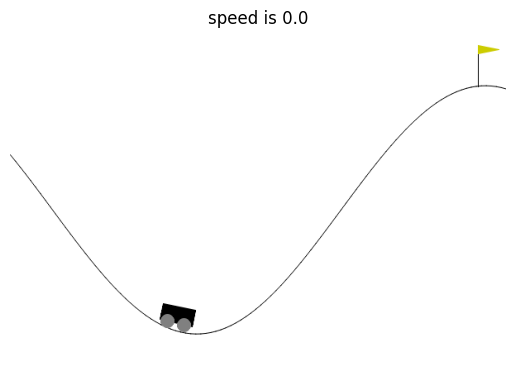

10


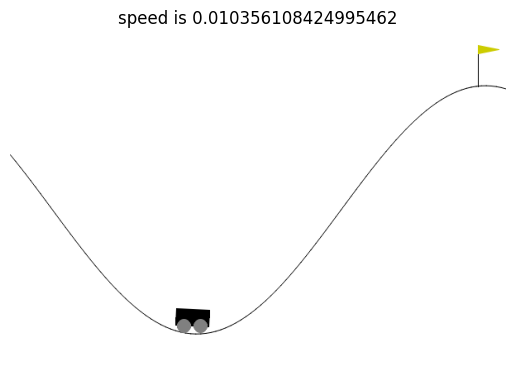

20


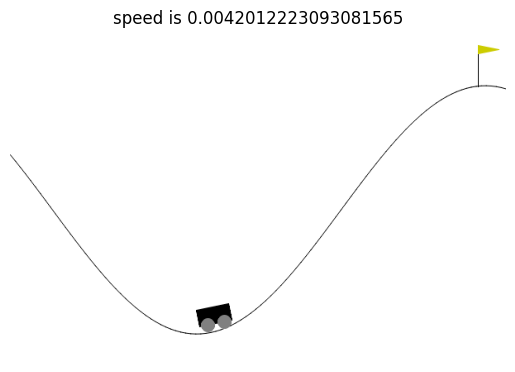

30


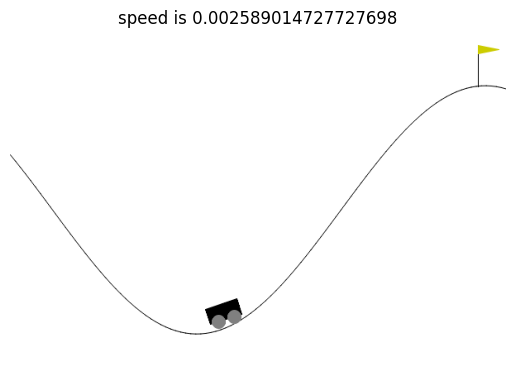

40


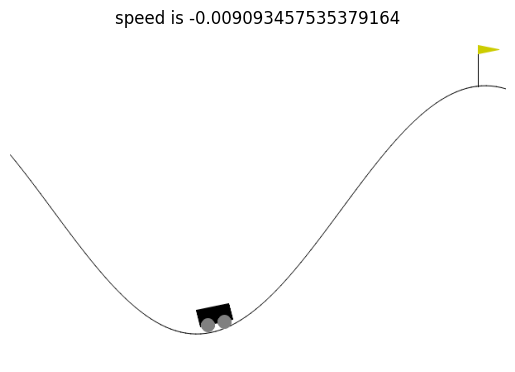

50


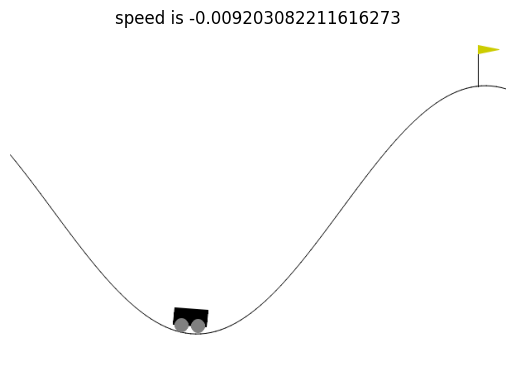

60


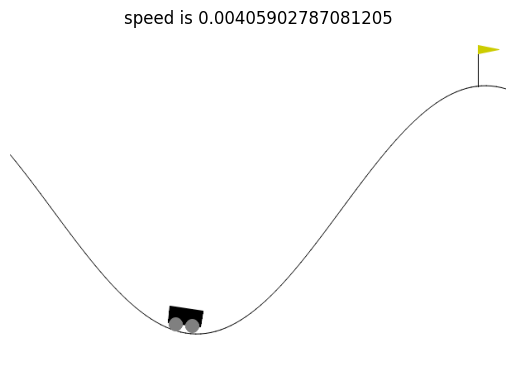

70


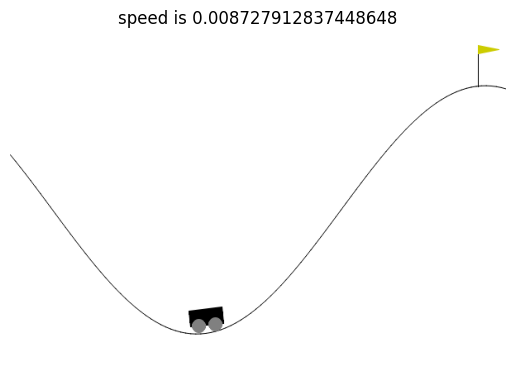

80


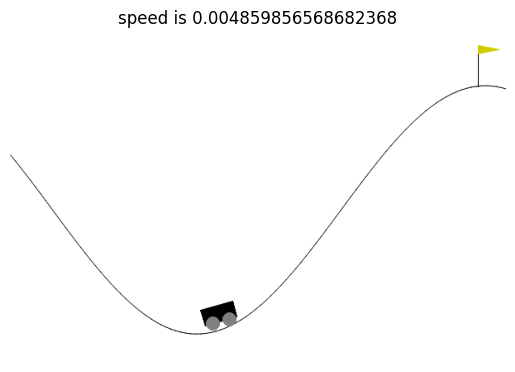

90


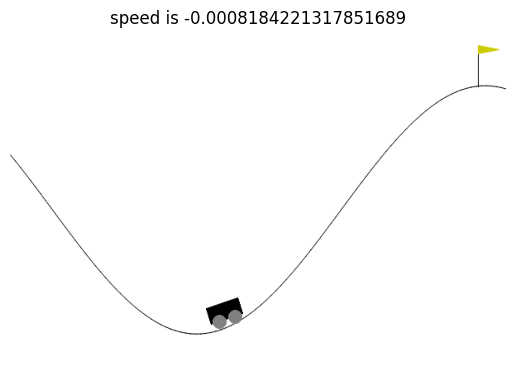

100


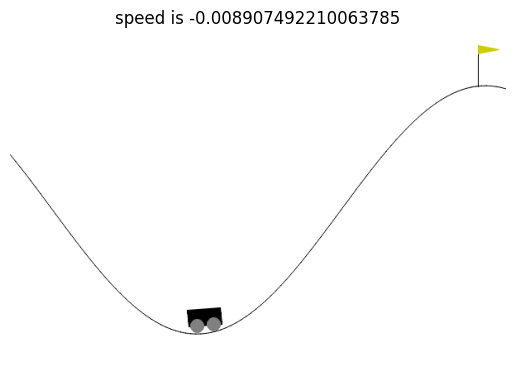

110


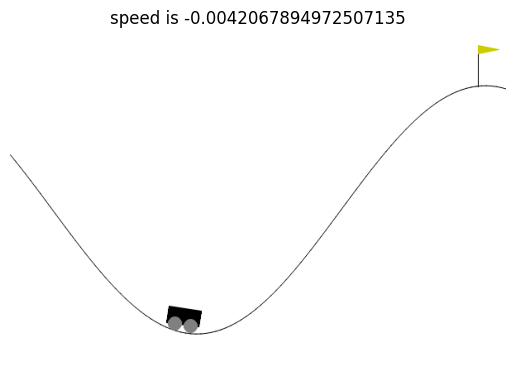

120


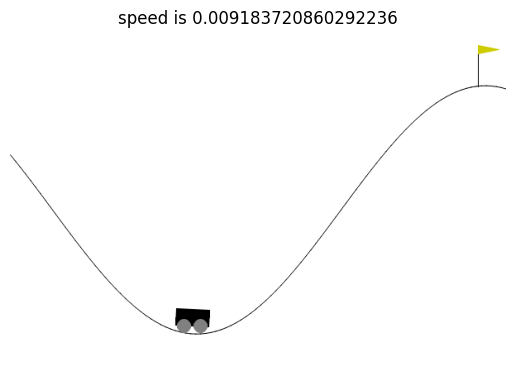

130


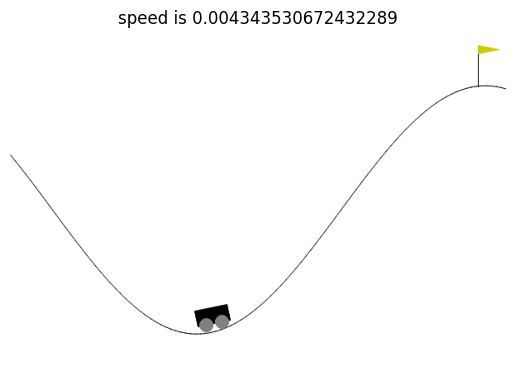

140


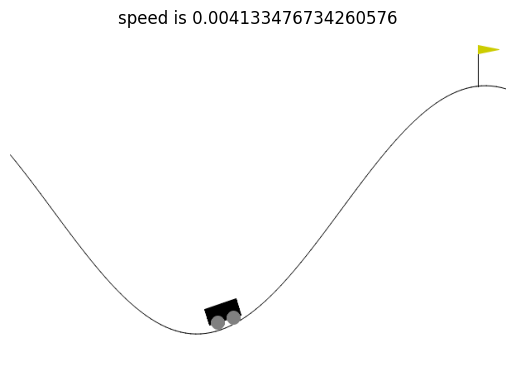

150


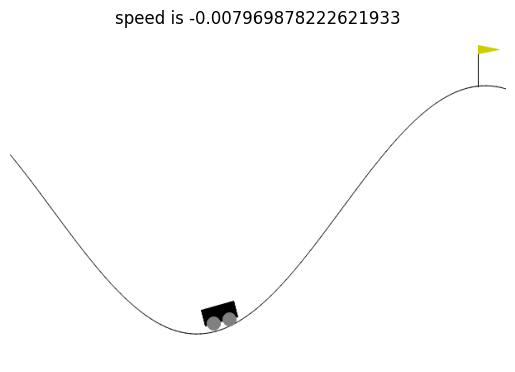

160


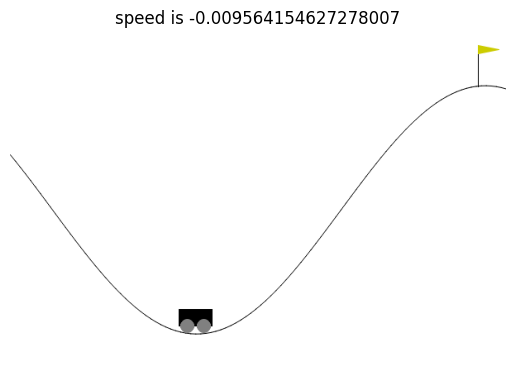

170


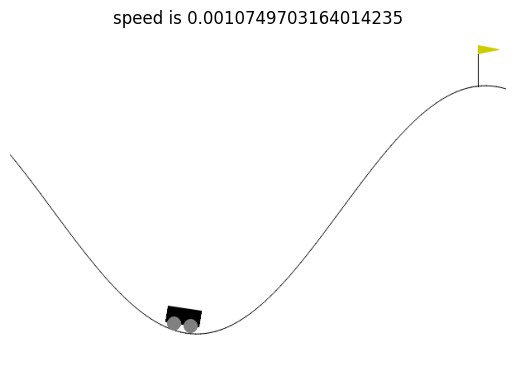

180


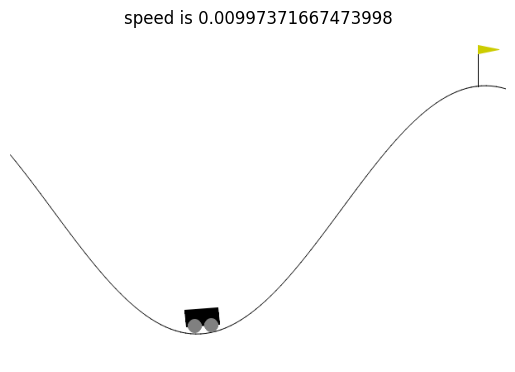

190


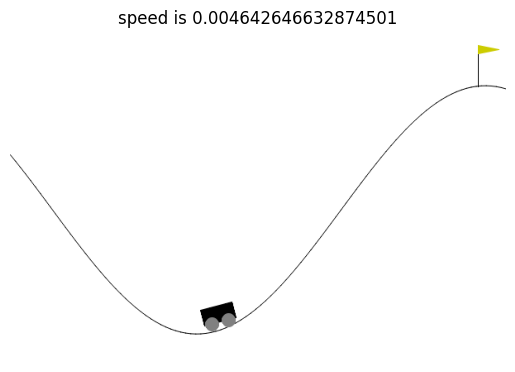

Average Reward = -200.0
Win Percentage = 0 %


In [10]:
mountain_car_ql.create_policy()
result = mountain_car_ql.evaluate(num_episodes=300)
print('Average Reward =', result[0])
print('Win Percentage =', result[1], '%')

show the path your car took for only one episode. Use visualize function every 10 frame.

In [11]:
# visualization done through previous part (inlcuded in evaluate)

## SARSA
now we want to use sarsa algorithm here instead of Q learning. The update rule is:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$

In [12]:
class MountainCarSarsa(MountainCarQL):

    def learn(self, num_episodes, alpha, gamma, epsilon):
        for e in range(num_episodes):
            state = self.env.reset()[0]
            discrete_state = self.get_discrete_state(state)
            if np.random.random() < epsilon:
                action = self.env.action_space.sample()
            else:
                action = np.argmax(self.q_values[discrete_state])
            end = False
            
            while not end:
                new_state, reward, is_terminated, is_truncated, info = self.env.step(action)
                new_discrete_state = self.get_discrete_state(new_state)
                if np.random.random() < epsilon:
                    new_action = self.env.action_space.sample()
                else:
                    new_action = np.argmax(self.q_values[new_discrete_state])
                end = is_terminated or is_truncated
                
                best_new_q = self.q_values[new_discrete_state + (new_action, )]
                current_q = self.q_values[discrete_state + (action, )]
                updated_q = (1 - alpha) * current_q + alpha * (reward + gamma * best_new_q)
                self.q_values[discrete_state + (action, )] = updated_q
                if end and new_state[0] > self.env.goal_position:
                    print('Achieved Goal in iteration', e)
                    self.q_values[discrete_state + (action, )] = 10
                    
                discrete_state = new_discrete_state
                action = new_action

train your agent with good parameters

In [13]:
EPISODES = 10000
LEARNING_RATE = 0.3
DISCOUNT = 0.95
EPSILON = 0.3
DISCRETE_SIZE = 30

mountain_car_sarsa = MountainCarSarsa(env,discrete_size=DISCRETE_SIZE)
mountain_car_sarsa.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)


Achieved Goal in iteration 0
Achieved Goal in iteration 1
Achieved Goal in iteration 2
Achieved Goal in iteration 3
Achieved Goal in iteration 4
Achieved Goal in iteration 5
Achieved Goal in iteration 6
Achieved Goal in iteration 7
Achieved Goal in iteration 8
Achieved Goal in iteration 9
Achieved Goal in iteration 10
Achieved Goal in iteration 11
Achieved Goal in iteration 12
Achieved Goal in iteration 13
Achieved Goal in iteration 14
Achieved Goal in iteration 15
Achieved Goal in iteration 16
Achieved Goal in iteration 17
Achieved Goal in iteration 18
Achieved Goal in iteration 19
Achieved Goal in iteration 20
Achieved Goal in iteration 21
Achieved Goal in iteration 23
Achieved Goal in iteration 25
Achieved Goal in iteration 26
Achieved Goal in iteration 27
Achieved Goal in iteration 29
Achieved Goal in iteration 30
Achieved Goal in iteration 31
Achieved Goal in iteration 32
Achieved Goal in iteration 33
Achieved Goal in iteration 34
Achieved Goal in iteration 35
Achieved Goal in ite

Achieved Goal in iteration 517
Achieved Goal in iteration 519
Achieved Goal in iteration 521
Achieved Goal in iteration 522
Achieved Goal in iteration 523
Achieved Goal in iteration 524
Achieved Goal in iteration 531
Achieved Goal in iteration 534
Achieved Goal in iteration 535
Achieved Goal in iteration 536
Achieved Goal in iteration 539
Achieved Goal in iteration 540
Achieved Goal in iteration 541
Achieved Goal in iteration 544
Achieved Goal in iteration 545
Achieved Goal in iteration 546
Achieved Goal in iteration 547
Achieved Goal in iteration 548
Achieved Goal in iteration 549
Achieved Goal in iteration 551
Achieved Goal in iteration 553
Achieved Goal in iteration 554
Achieved Goal in iteration 555
Achieved Goal in iteration 561
Achieved Goal in iteration 564
Achieved Goal in iteration 565
Achieved Goal in iteration 566
Achieved Goal in iteration 569
Achieved Goal in iteration 570
Achieved Goal in iteration 571
Achieved Goal in iteration 573
Achieved Goal in iteration 575
Achieved

Achieved Goal in iteration 1080
Achieved Goal in iteration 1082
Achieved Goal in iteration 1083
Achieved Goal in iteration 1084
Achieved Goal in iteration 1085
Achieved Goal in iteration 1088
Achieved Goal in iteration 1089
Achieved Goal in iteration 1096
Achieved Goal in iteration 1098
Achieved Goal in iteration 1099
Achieved Goal in iteration 1101
Achieved Goal in iteration 1105
Achieved Goal in iteration 1107
Achieved Goal in iteration 1108
Achieved Goal in iteration 1109
Achieved Goal in iteration 1110
Achieved Goal in iteration 1111
Achieved Goal in iteration 1112
Achieved Goal in iteration 1114
Achieved Goal in iteration 1115
Achieved Goal in iteration 1117
Achieved Goal in iteration 1119
Achieved Goal in iteration 1120
Achieved Goal in iteration 1121
Achieved Goal in iteration 1122
Achieved Goal in iteration 1125
Achieved Goal in iteration 1128
Achieved Goal in iteration 1129
Achieved Goal in iteration 1130
Achieved Goal in iteration 1132
Achieved Goal in iteration 1133
Achieved

Achieved Goal in iteration 1484
Achieved Goal in iteration 1485
Achieved Goal in iteration 1486
Achieved Goal in iteration 1487
Achieved Goal in iteration 1488
Achieved Goal in iteration 1489
Achieved Goal in iteration 1490
Achieved Goal in iteration 1491
Achieved Goal in iteration 1492
Achieved Goal in iteration 1493
Achieved Goal in iteration 1494
Achieved Goal in iteration 1495
Achieved Goal in iteration 1496
Achieved Goal in iteration 1497
Achieved Goal in iteration 1498
Achieved Goal in iteration 1499
Achieved Goal in iteration 1500
Achieved Goal in iteration 1501
Achieved Goal in iteration 1502
Achieved Goal in iteration 1503
Achieved Goal in iteration 1504
Achieved Goal in iteration 1505
Achieved Goal in iteration 1506
Achieved Goal in iteration 1507
Achieved Goal in iteration 1508
Achieved Goal in iteration 1509
Achieved Goal in iteration 1510
Achieved Goal in iteration 1511
Achieved Goal in iteration 1512
Achieved Goal in iteration 1513
Achieved Goal in iteration 1514
Achieved

Achieved Goal in iteration 1750
Achieved Goal in iteration 1751
Achieved Goal in iteration 1752
Achieved Goal in iteration 1753
Achieved Goal in iteration 1754
Achieved Goal in iteration 1755
Achieved Goal in iteration 1756
Achieved Goal in iteration 1757
Achieved Goal in iteration 1758
Achieved Goal in iteration 1759
Achieved Goal in iteration 1760
Achieved Goal in iteration 1761
Achieved Goal in iteration 1762
Achieved Goal in iteration 1763
Achieved Goal in iteration 1764
Achieved Goal in iteration 1765
Achieved Goal in iteration 1766
Achieved Goal in iteration 1767
Achieved Goal in iteration 1768
Achieved Goal in iteration 1769
Achieved Goal in iteration 1770
Achieved Goal in iteration 1771
Achieved Goal in iteration 1772
Achieved Goal in iteration 1773
Achieved Goal in iteration 1774
Achieved Goal in iteration 1775
Achieved Goal in iteration 1776
Achieved Goal in iteration 1777
Achieved Goal in iteration 1778
Achieved Goal in iteration 1779
Achieved Goal in iteration 1780
Achieved

Achieved Goal in iteration 2123
Achieved Goal in iteration 2124
Achieved Goal in iteration 2125
Achieved Goal in iteration 2126
Achieved Goal in iteration 2128
Achieved Goal in iteration 2129
Achieved Goal in iteration 2130
Achieved Goal in iteration 2131
Achieved Goal in iteration 2132
Achieved Goal in iteration 2133
Achieved Goal in iteration 2134
Achieved Goal in iteration 2135
Achieved Goal in iteration 2137
Achieved Goal in iteration 2138
Achieved Goal in iteration 2139
Achieved Goal in iteration 2140
Achieved Goal in iteration 2142
Achieved Goal in iteration 2144
Achieved Goal in iteration 2146
Achieved Goal in iteration 2148
Achieved Goal in iteration 2149
Achieved Goal in iteration 2150
Achieved Goal in iteration 2152
Achieved Goal in iteration 2153
Achieved Goal in iteration 2154
Achieved Goal in iteration 2155
Achieved Goal in iteration 2156
Achieved Goal in iteration 2158
Achieved Goal in iteration 2161
Achieved Goal in iteration 2165
Achieved Goal in iteration 2166
Achieved

Achieved Goal in iteration 2459
Achieved Goal in iteration 2461
Achieved Goal in iteration 2462
Achieved Goal in iteration 2463
Achieved Goal in iteration 2464
Achieved Goal in iteration 2466
Achieved Goal in iteration 2467
Achieved Goal in iteration 2468
Achieved Goal in iteration 2469
Achieved Goal in iteration 2470
Achieved Goal in iteration 2473
Achieved Goal in iteration 2475
Achieved Goal in iteration 2476
Achieved Goal in iteration 2477
Achieved Goal in iteration 2478
Achieved Goal in iteration 2479
Achieved Goal in iteration 2480
Achieved Goal in iteration 2481
Achieved Goal in iteration 2482
Achieved Goal in iteration 2483
Achieved Goal in iteration 2484
Achieved Goal in iteration 2485
Achieved Goal in iteration 2486
Achieved Goal in iteration 2487
Achieved Goal in iteration 2489
Achieved Goal in iteration 2490
Achieved Goal in iteration 2492
Achieved Goal in iteration 2493
Achieved Goal in iteration 2494
Achieved Goal in iteration 2495
Achieved Goal in iteration 2496
Achieved

Achieved Goal in iteration 2834
Achieved Goal in iteration 2836
Achieved Goal in iteration 2838
Achieved Goal in iteration 2839
Achieved Goal in iteration 2841
Achieved Goal in iteration 2842
Achieved Goal in iteration 2844
Achieved Goal in iteration 2845
Achieved Goal in iteration 2846
Achieved Goal in iteration 2847
Achieved Goal in iteration 2848
Achieved Goal in iteration 2853
Achieved Goal in iteration 2854
Achieved Goal in iteration 2855
Achieved Goal in iteration 2856
Achieved Goal in iteration 2857
Achieved Goal in iteration 2860
Achieved Goal in iteration 2864
Achieved Goal in iteration 2865
Achieved Goal in iteration 2869
Achieved Goal in iteration 2873
Achieved Goal in iteration 2875
Achieved Goal in iteration 2881
Achieved Goal in iteration 2884
Achieved Goal in iteration 2886
Achieved Goal in iteration 2887
Achieved Goal in iteration 2889
Achieved Goal in iteration 2891
Achieved Goal in iteration 2893
Achieved Goal in iteration 2894
Achieved Goal in iteration 2899
Achieved

Achieved Goal in iteration 3416
Achieved Goal in iteration 3417
Achieved Goal in iteration 3418
Achieved Goal in iteration 3419
Achieved Goal in iteration 3422
Achieved Goal in iteration 3425
Achieved Goal in iteration 3426
Achieved Goal in iteration 3430
Achieved Goal in iteration 3432
Achieved Goal in iteration 3433
Achieved Goal in iteration 3436
Achieved Goal in iteration 3437
Achieved Goal in iteration 3438
Achieved Goal in iteration 3439
Achieved Goal in iteration 3440
Achieved Goal in iteration 3444
Achieved Goal in iteration 3445
Achieved Goal in iteration 3449
Achieved Goal in iteration 3452
Achieved Goal in iteration 3454
Achieved Goal in iteration 3456
Achieved Goal in iteration 3461
Achieved Goal in iteration 3462
Achieved Goal in iteration 3463
Achieved Goal in iteration 3472
Achieved Goal in iteration 3474
Achieved Goal in iteration 3475
Achieved Goal in iteration 3478
Achieved Goal in iteration 3480
Achieved Goal in iteration 3486
Achieved Goal in iteration 3487
Achieved

Achieved Goal in iteration 4076
Achieved Goal in iteration 4077
Achieved Goal in iteration 4078
Achieved Goal in iteration 4080
Achieved Goal in iteration 4083
Achieved Goal in iteration 4085
Achieved Goal in iteration 4086
Achieved Goal in iteration 4087
Achieved Goal in iteration 4095
Achieved Goal in iteration 4097
Achieved Goal in iteration 4101
Achieved Goal in iteration 4102
Achieved Goal in iteration 4103
Achieved Goal in iteration 4104
Achieved Goal in iteration 4105
Achieved Goal in iteration 4106
Achieved Goal in iteration 4108
Achieved Goal in iteration 4109
Achieved Goal in iteration 4113
Achieved Goal in iteration 4114
Achieved Goal in iteration 4117
Achieved Goal in iteration 4119
Achieved Goal in iteration 4120
Achieved Goal in iteration 4121
Achieved Goal in iteration 4123
Achieved Goal in iteration 4124
Achieved Goal in iteration 4127
Achieved Goal in iteration 4130
Achieved Goal in iteration 4132
Achieved Goal in iteration 4134
Achieved Goal in iteration 4136
Achieved

Achieved Goal in iteration 4518
Achieved Goal in iteration 4519
Achieved Goal in iteration 4520
Achieved Goal in iteration 4521
Achieved Goal in iteration 4522
Achieved Goal in iteration 4523
Achieved Goal in iteration 4524
Achieved Goal in iteration 4525
Achieved Goal in iteration 4526
Achieved Goal in iteration 4527
Achieved Goal in iteration 4528
Achieved Goal in iteration 4529
Achieved Goal in iteration 4530
Achieved Goal in iteration 4531
Achieved Goal in iteration 4532
Achieved Goal in iteration 4533
Achieved Goal in iteration 4534
Achieved Goal in iteration 4535
Achieved Goal in iteration 4536
Achieved Goal in iteration 4537
Achieved Goal in iteration 4538
Achieved Goal in iteration 4539
Achieved Goal in iteration 4540
Achieved Goal in iteration 4541
Achieved Goal in iteration 4542
Achieved Goal in iteration 4543
Achieved Goal in iteration 4544
Achieved Goal in iteration 4545
Achieved Goal in iteration 4546
Achieved Goal in iteration 4547
Achieved Goal in iteration 4548
Achieved

Achieved Goal in iteration 4860
Achieved Goal in iteration 4861
Achieved Goal in iteration 4862
Achieved Goal in iteration 4863
Achieved Goal in iteration 4864
Achieved Goal in iteration 4865
Achieved Goal in iteration 4866
Achieved Goal in iteration 4867
Achieved Goal in iteration 4869
Achieved Goal in iteration 4870
Achieved Goal in iteration 4871
Achieved Goal in iteration 4872
Achieved Goal in iteration 4874
Achieved Goal in iteration 4875
Achieved Goal in iteration 4876
Achieved Goal in iteration 4877
Achieved Goal in iteration 4878
Achieved Goal in iteration 4879
Achieved Goal in iteration 4881
Achieved Goal in iteration 4882
Achieved Goal in iteration 4883
Achieved Goal in iteration 4884
Achieved Goal in iteration 4885
Achieved Goal in iteration 4887
Achieved Goal in iteration 4888
Achieved Goal in iteration 4889
Achieved Goal in iteration 4890
Achieved Goal in iteration 4891
Achieved Goal in iteration 4892
Achieved Goal in iteration 4893
Achieved Goal in iteration 4894
Achieved

Achieved Goal in iteration 5190
Achieved Goal in iteration 5191
Achieved Goal in iteration 5193
Achieved Goal in iteration 5194
Achieved Goal in iteration 5195
Achieved Goal in iteration 5196
Achieved Goal in iteration 5197
Achieved Goal in iteration 5198
Achieved Goal in iteration 5199
Achieved Goal in iteration 5200
Achieved Goal in iteration 5201
Achieved Goal in iteration 5202
Achieved Goal in iteration 5203
Achieved Goal in iteration 5204
Achieved Goal in iteration 5206
Achieved Goal in iteration 5207
Achieved Goal in iteration 5208
Achieved Goal in iteration 5209
Achieved Goal in iteration 5210
Achieved Goal in iteration 5211
Achieved Goal in iteration 5212
Achieved Goal in iteration 5213
Achieved Goal in iteration 5215
Achieved Goal in iteration 5216
Achieved Goal in iteration 5217
Achieved Goal in iteration 5218
Achieved Goal in iteration 5220
Achieved Goal in iteration 5221
Achieved Goal in iteration 5222
Achieved Goal in iteration 5224
Achieved Goal in iteration 5225
Achieved

Achieved Goal in iteration 5586
Achieved Goal in iteration 5588
Achieved Goal in iteration 5589
Achieved Goal in iteration 5590
Achieved Goal in iteration 5591
Achieved Goal in iteration 5592
Achieved Goal in iteration 5593
Achieved Goal in iteration 5594
Achieved Goal in iteration 5595
Achieved Goal in iteration 5596
Achieved Goal in iteration 5597
Achieved Goal in iteration 5598
Achieved Goal in iteration 5599
Achieved Goal in iteration 5600
Achieved Goal in iteration 5601
Achieved Goal in iteration 5602
Achieved Goal in iteration 5603
Achieved Goal in iteration 5605
Achieved Goal in iteration 5606
Achieved Goal in iteration 5607
Achieved Goal in iteration 5608
Achieved Goal in iteration 5609
Achieved Goal in iteration 5610
Achieved Goal in iteration 5612
Achieved Goal in iteration 5614
Achieved Goal in iteration 5615
Achieved Goal in iteration 5616
Achieved Goal in iteration 5617
Achieved Goal in iteration 5618
Achieved Goal in iteration 5621
Achieved Goal in iteration 5622
Achieved

Achieved Goal in iteration 5918
Achieved Goal in iteration 5919
Achieved Goal in iteration 5920
Achieved Goal in iteration 5921
Achieved Goal in iteration 5922
Achieved Goal in iteration 5923
Achieved Goal in iteration 5924
Achieved Goal in iteration 5925
Achieved Goal in iteration 5926
Achieved Goal in iteration 5927
Achieved Goal in iteration 5929
Achieved Goal in iteration 5930
Achieved Goal in iteration 5931
Achieved Goal in iteration 5932
Achieved Goal in iteration 5933
Achieved Goal in iteration 5934
Achieved Goal in iteration 5935
Achieved Goal in iteration 5939
Achieved Goal in iteration 5940
Achieved Goal in iteration 5942
Achieved Goal in iteration 5943
Achieved Goal in iteration 5944
Achieved Goal in iteration 5945
Achieved Goal in iteration 5946
Achieved Goal in iteration 5948
Achieved Goal in iteration 5949
Achieved Goal in iteration 5950
Achieved Goal in iteration 5951
Achieved Goal in iteration 5952
Achieved Goal in iteration 5954
Achieved Goal in iteration 5956
Achieved

Achieved Goal in iteration 6266
Achieved Goal in iteration 6267
Achieved Goal in iteration 6268
Achieved Goal in iteration 6269
Achieved Goal in iteration 6270
Achieved Goal in iteration 6271
Achieved Goal in iteration 6272
Achieved Goal in iteration 6273
Achieved Goal in iteration 6274
Achieved Goal in iteration 6275
Achieved Goal in iteration 6277
Achieved Goal in iteration 6278
Achieved Goal in iteration 6279
Achieved Goal in iteration 6282
Achieved Goal in iteration 6283
Achieved Goal in iteration 6284
Achieved Goal in iteration 6285
Achieved Goal in iteration 6287
Achieved Goal in iteration 6288
Achieved Goal in iteration 6290
Achieved Goal in iteration 6291
Achieved Goal in iteration 6292
Achieved Goal in iteration 6293
Achieved Goal in iteration 6295
Achieved Goal in iteration 6298
Achieved Goal in iteration 6300
Achieved Goal in iteration 6305
Achieved Goal in iteration 6308
Achieved Goal in iteration 6309
Achieved Goal in iteration 6310
Achieved Goal in iteration 6311
Achieved

Achieved Goal in iteration 6684
Achieved Goal in iteration 6685
Achieved Goal in iteration 6686
Achieved Goal in iteration 6687
Achieved Goal in iteration 6688
Achieved Goal in iteration 6689
Achieved Goal in iteration 6691
Achieved Goal in iteration 6692
Achieved Goal in iteration 6693
Achieved Goal in iteration 6694
Achieved Goal in iteration 6696
Achieved Goal in iteration 6697
Achieved Goal in iteration 6698
Achieved Goal in iteration 6699
Achieved Goal in iteration 6700
Achieved Goal in iteration 6701
Achieved Goal in iteration 6702
Achieved Goal in iteration 6703
Achieved Goal in iteration 6704
Achieved Goal in iteration 6705
Achieved Goal in iteration 6706
Achieved Goal in iteration 6710
Achieved Goal in iteration 6711
Achieved Goal in iteration 6712
Achieved Goal in iteration 6713
Achieved Goal in iteration 6714
Achieved Goal in iteration 6716
Achieved Goal in iteration 6717
Achieved Goal in iteration 6718
Achieved Goal in iteration 6720
Achieved Goal in iteration 6721
Achieved

Achieved Goal in iteration 7059
Achieved Goal in iteration 7061
Achieved Goal in iteration 7062
Achieved Goal in iteration 7063
Achieved Goal in iteration 7064
Achieved Goal in iteration 7065
Achieved Goal in iteration 7066
Achieved Goal in iteration 7067
Achieved Goal in iteration 7068
Achieved Goal in iteration 7069
Achieved Goal in iteration 7070
Achieved Goal in iteration 7071
Achieved Goal in iteration 7072
Achieved Goal in iteration 7074
Achieved Goal in iteration 7076
Achieved Goal in iteration 7078
Achieved Goal in iteration 7079
Achieved Goal in iteration 7080
Achieved Goal in iteration 7082
Achieved Goal in iteration 7083
Achieved Goal in iteration 7085
Achieved Goal in iteration 7086
Achieved Goal in iteration 7087
Achieved Goal in iteration 7088
Achieved Goal in iteration 7089
Achieved Goal in iteration 7090
Achieved Goal in iteration 7091
Achieved Goal in iteration 7092
Achieved Goal in iteration 7093
Achieved Goal in iteration 7094
Achieved Goal in iteration 7095
Achieved

Achieved Goal in iteration 7438
Achieved Goal in iteration 7440
Achieved Goal in iteration 7443
Achieved Goal in iteration 7444
Achieved Goal in iteration 7446
Achieved Goal in iteration 7447
Achieved Goal in iteration 7448
Achieved Goal in iteration 7450
Achieved Goal in iteration 7451
Achieved Goal in iteration 7452
Achieved Goal in iteration 7453
Achieved Goal in iteration 7455
Achieved Goal in iteration 7456
Achieved Goal in iteration 7457
Achieved Goal in iteration 7458
Achieved Goal in iteration 7459
Achieved Goal in iteration 7460
Achieved Goal in iteration 7464
Achieved Goal in iteration 7466
Achieved Goal in iteration 7469
Achieved Goal in iteration 7470
Achieved Goal in iteration 7473
Achieved Goal in iteration 7475
Achieved Goal in iteration 7476
Achieved Goal in iteration 7477
Achieved Goal in iteration 7478
Achieved Goal in iteration 7479
Achieved Goal in iteration 7480
Achieved Goal in iteration 7481
Achieved Goal in iteration 7483
Achieved Goal in iteration 7484
Achieved

Achieved Goal in iteration 7989
Achieved Goal in iteration 7990
Achieved Goal in iteration 7991
Achieved Goal in iteration 7992
Achieved Goal in iteration 7993
Achieved Goal in iteration 7994
Achieved Goal in iteration 7995
Achieved Goal in iteration 7997
Achieved Goal in iteration 8000
Achieved Goal in iteration 8003
Achieved Goal in iteration 8005
Achieved Goal in iteration 8006
Achieved Goal in iteration 8008
Achieved Goal in iteration 8010
Achieved Goal in iteration 8011
Achieved Goal in iteration 8012
Achieved Goal in iteration 8014
Achieved Goal in iteration 8015
Achieved Goal in iteration 8016
Achieved Goal in iteration 8019
Achieved Goal in iteration 8022
Achieved Goal in iteration 8024
Achieved Goal in iteration 8027
Achieved Goal in iteration 8028
Achieved Goal in iteration 8029
Achieved Goal in iteration 8033
Achieved Goal in iteration 8035
Achieved Goal in iteration 8037
Achieved Goal in iteration 8048
Achieved Goal in iteration 8049
Achieved Goal in iteration 8051
Achieved

Achieved Goal in iteration 8504
Achieved Goal in iteration 8510
Achieved Goal in iteration 8511
Achieved Goal in iteration 8512
Achieved Goal in iteration 8513
Achieved Goal in iteration 8516
Achieved Goal in iteration 8518
Achieved Goal in iteration 8519
Achieved Goal in iteration 8522
Achieved Goal in iteration 8525
Achieved Goal in iteration 8526
Achieved Goal in iteration 8529
Achieved Goal in iteration 8530
Achieved Goal in iteration 8531
Achieved Goal in iteration 8532
Achieved Goal in iteration 8533
Achieved Goal in iteration 8535
Achieved Goal in iteration 8536
Achieved Goal in iteration 8539
Achieved Goal in iteration 8540
Achieved Goal in iteration 8542
Achieved Goal in iteration 8543
Achieved Goal in iteration 8545
Achieved Goal in iteration 8546
Achieved Goal in iteration 8549
Achieved Goal in iteration 8550
Achieved Goal in iteration 8553
Achieved Goal in iteration 8557
Achieved Goal in iteration 8558
Achieved Goal in iteration 8559
Achieved Goal in iteration 8560
Achieved

Achieved Goal in iteration 8808
Achieved Goal in iteration 8809
Achieved Goal in iteration 8810
Achieved Goal in iteration 8811
Achieved Goal in iteration 8812
Achieved Goal in iteration 8813
Achieved Goal in iteration 8814
Achieved Goal in iteration 8815
Achieved Goal in iteration 8816
Achieved Goal in iteration 8817
Achieved Goal in iteration 8818
Achieved Goal in iteration 8819
Achieved Goal in iteration 8820
Achieved Goal in iteration 8821
Achieved Goal in iteration 8822
Achieved Goal in iteration 8823
Achieved Goal in iteration 8824
Achieved Goal in iteration 8825
Achieved Goal in iteration 8826
Achieved Goal in iteration 8827
Achieved Goal in iteration 8828
Achieved Goal in iteration 8829
Achieved Goal in iteration 8830
Achieved Goal in iteration 8831
Achieved Goal in iteration 8832
Achieved Goal in iteration 8833
Achieved Goal in iteration 8834
Achieved Goal in iteration 8835
Achieved Goal in iteration 8836
Achieved Goal in iteration 8837
Achieved Goal in iteration 8838
Achieved

Achieved Goal in iteration 9114
Achieved Goal in iteration 9115
Achieved Goal in iteration 9116
Achieved Goal in iteration 9117
Achieved Goal in iteration 9118
Achieved Goal in iteration 9119
Achieved Goal in iteration 9120
Achieved Goal in iteration 9121
Achieved Goal in iteration 9123
Achieved Goal in iteration 9124
Achieved Goal in iteration 9126
Achieved Goal in iteration 9127
Achieved Goal in iteration 9128
Achieved Goal in iteration 9129
Achieved Goal in iteration 9130
Achieved Goal in iteration 9131
Achieved Goal in iteration 9132
Achieved Goal in iteration 9133
Achieved Goal in iteration 9134
Achieved Goal in iteration 9135
Achieved Goal in iteration 9136
Achieved Goal in iteration 9137
Achieved Goal in iteration 9138
Achieved Goal in iteration 9140
Achieved Goal in iteration 9141
Achieved Goal in iteration 9144
Achieved Goal in iteration 9145
Achieved Goal in iteration 9146
Achieved Goal in iteration 9149
Achieved Goal in iteration 9150
Achieved Goal in iteration 9151
Achieved

Achieved Goal in iteration 9505
Achieved Goal in iteration 9508
Achieved Goal in iteration 9509
Achieved Goal in iteration 9511
Achieved Goal in iteration 9514
Achieved Goal in iteration 9515
Achieved Goal in iteration 9517
Achieved Goal in iteration 9518
Achieved Goal in iteration 9521
Achieved Goal in iteration 9522
Achieved Goal in iteration 9523
Achieved Goal in iteration 9524
Achieved Goal in iteration 9525
Achieved Goal in iteration 9526
Achieved Goal in iteration 9527
Achieved Goal in iteration 9532
Achieved Goal in iteration 9535
Achieved Goal in iteration 9536
Achieved Goal in iteration 9537
Achieved Goal in iteration 9538
Achieved Goal in iteration 9540
Achieved Goal in iteration 9543
Achieved Goal in iteration 9544
Achieved Goal in iteration 9546
Achieved Goal in iteration 9548
Achieved Goal in iteration 9549
Achieved Goal in iteration 9550
Achieved Goal in iteration 9552
Achieved Goal in iteration 9553
Achieved Goal in iteration 9556
Achieved Goal in iteration 9557
Achieved

Achieved Goal in iteration 9959
Achieved Goal in iteration 9963
Achieved Goal in iteration 9964
Achieved Goal in iteration 9965
Achieved Goal in iteration 9966
Achieved Goal in iteration 9967
Achieved Goal in iteration 9971
Achieved Goal in iteration 9972
Achieved Goal in iteration 9973
Achieved Goal in iteration 9974
Achieved Goal in iteration 9980
Achieved Goal in iteration 9981
Achieved Goal in iteration 9982
Achieved Goal in iteration 9987
Achieved Goal in iteration 9988
Achieved Goal in iteration 9989
Achieved Goal in iteration 9990
Achieved Goal in iteration 9991
Achieved Goal in iteration 9992
Achieved Goal in iteration 9994
Achieved Goal in iteration 9995
Achieved Goal in iteration 9996


evaluate your agent with at list 200 episodes. your average score must be more than -175.

0


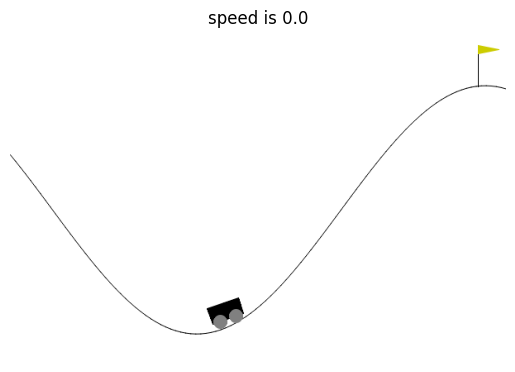

10


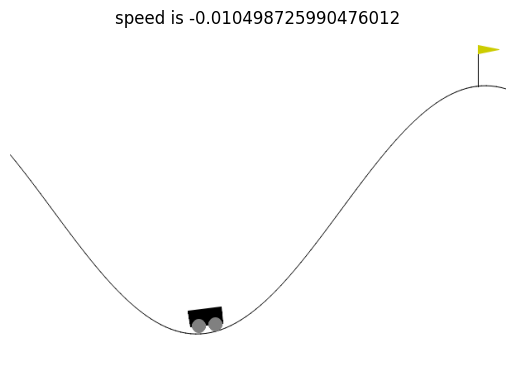

20


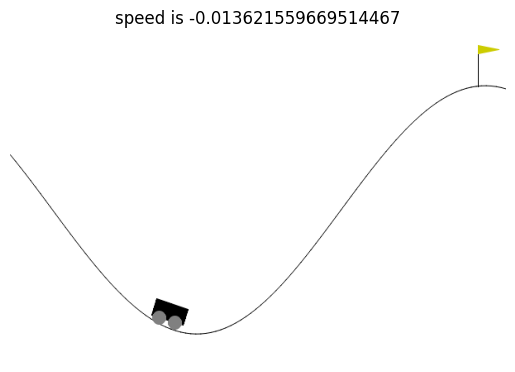

30


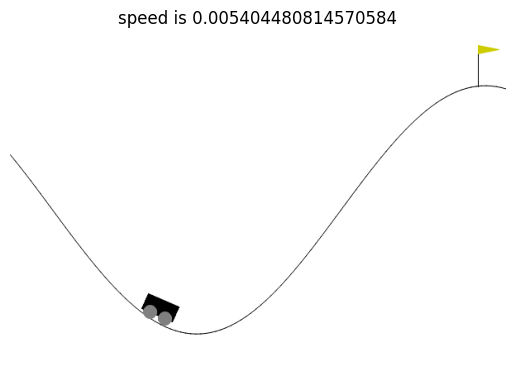

40


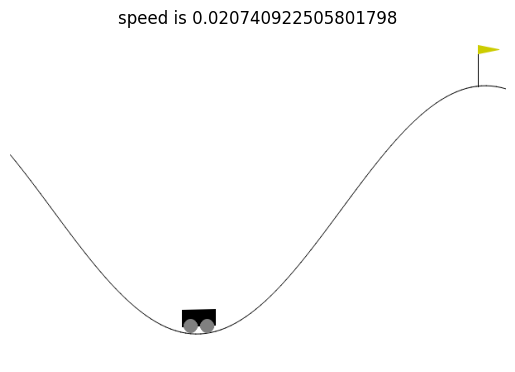

50


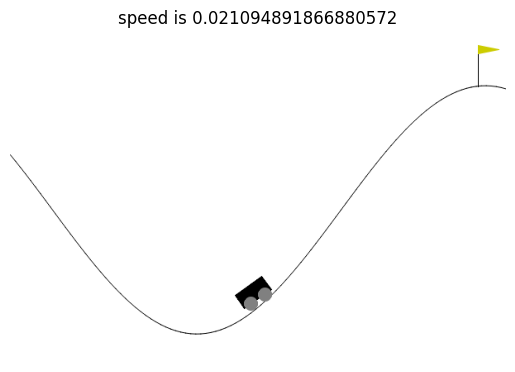

60


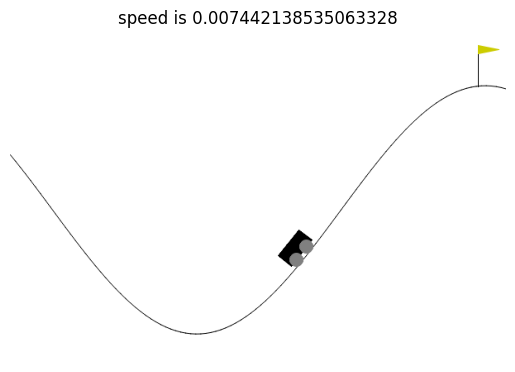

70


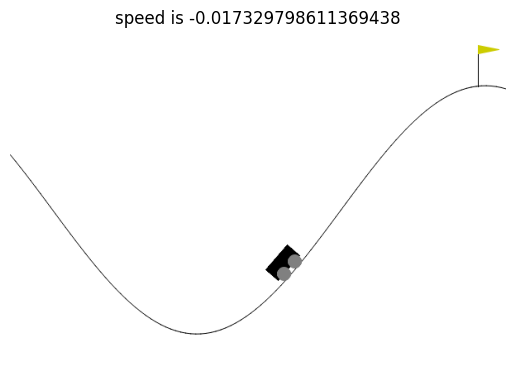

80


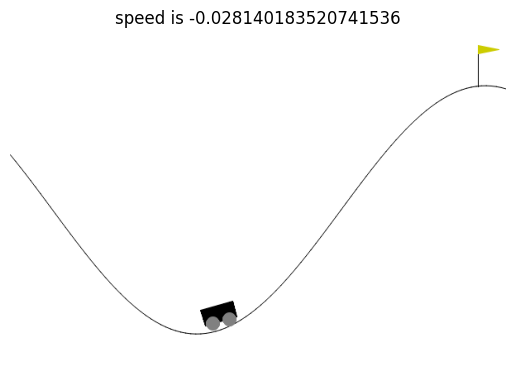

90


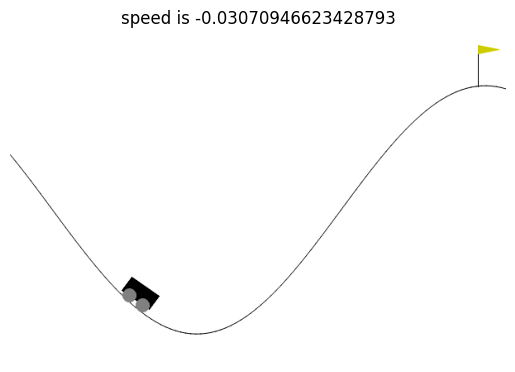

100


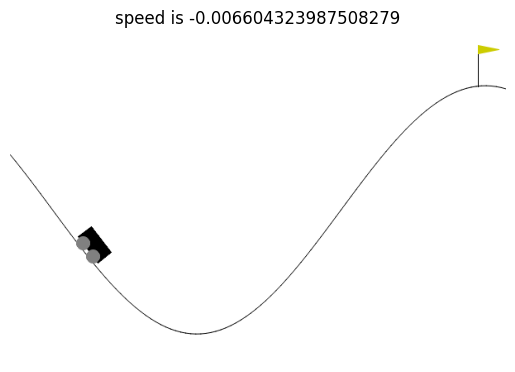

110


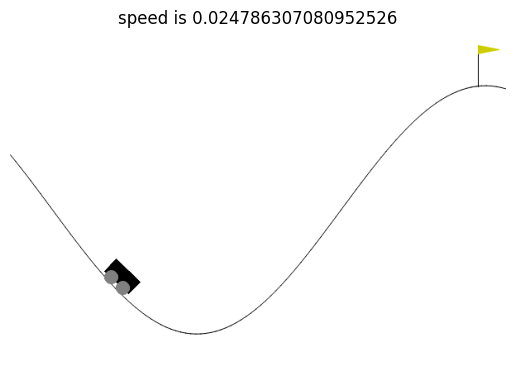

120


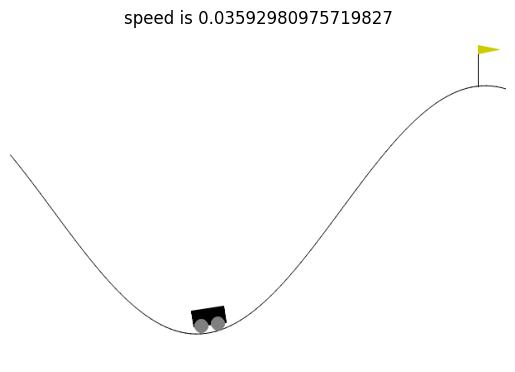

130


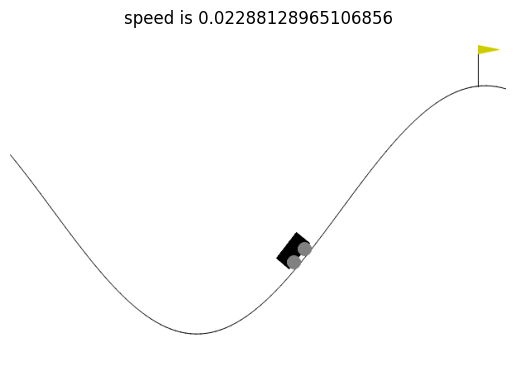

140


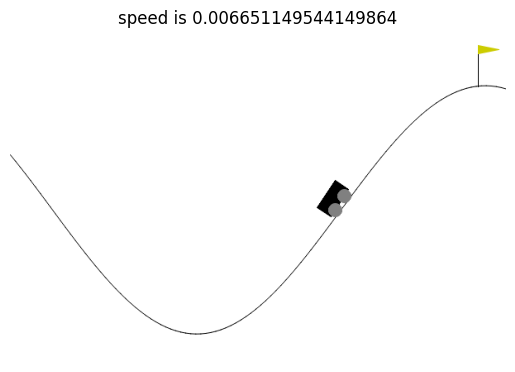

150


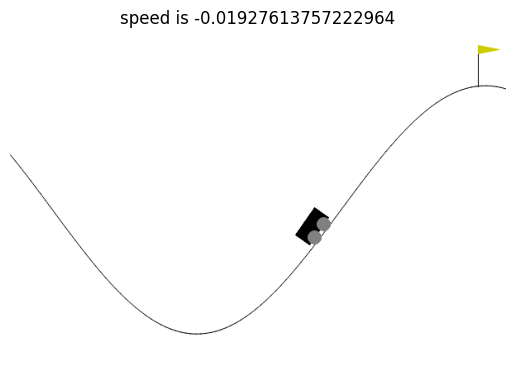

160


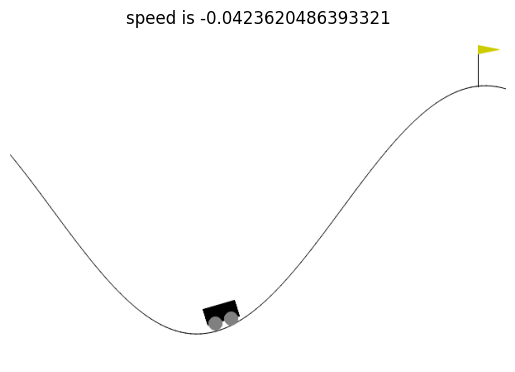

170


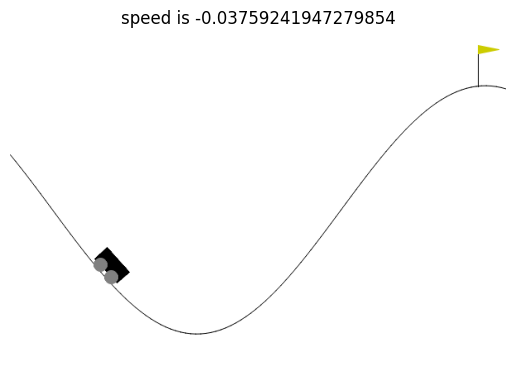

180


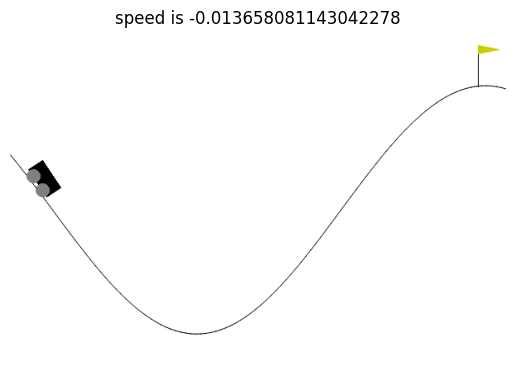

190


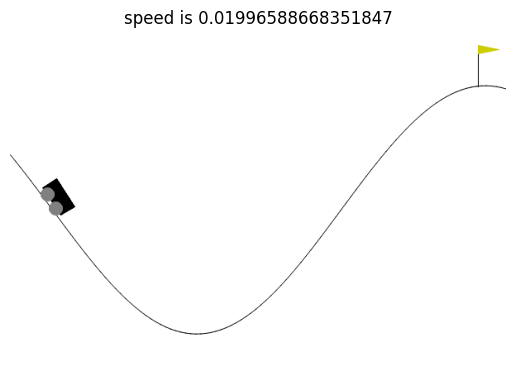

Average Reward = -200.0
Win Percentage = 0 %


In [14]:
mountain_car_sarsa.create_policy()
result = mountain_car_sarsa.evaluate(num_episodes=300)
print('Average Reward =', result[0])
print('Win Percentage =', result[1], '%')

show the path your car took for only one episode. Use visualize function every 10 frame.

In [15]:
# visualization done through previous part (inlcuded in evaluate)

Is there any difference between the two algorithms? Compare results and explain why.

Answer: SARSA is based on the best next acion, but Q-Learning is not like that; so SARSA does a little better.

(it's weired that the algorithms get lots of goal achievements through learning process, but don't do well in evaluating. It seems like the new_state given by the env.step(action) function is weird!)